In [1]:
import os

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [236]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
import platform
if platform.system() == 'Darwin': 
        plt.rc('font', family='AppleGothic') 
elif platform.system() == 'Windows': 
        plt.rc('font', family='Malgun Gothic') 
elif platform.system() == 'Linux': 
        plt.rc('font', family='NanumBarunGothic') ## google colab
plt.rcParams['axes.unicode_minus'] = False

In [4]:
try:
    os.chdir("C:\\Users\\SAMSUNG\\Desktop\\나\\기상청 공모전\\data") 
    print("Directory changed")
except OSError:
    print("Can't change the Current Working Directory")

Directory changed


# 1. 데이터 처리

In [5]:
back_hospital = pd.read_csv("back_hospital.csv", usecols=[1,2,3,4])
back_hospital.columns = ['yyyymmdd', 'area', 'sex', 'frequency']
back_hospital['yyyymmdd'] = pd.to_datetime(back_hospital['yyyymmdd'], format='%Y%m%d')
back_hospital.head(2)

,yyyymmdd,area,sex,frequency
0,2012-01-01,강원,1,3
1,2012-01-01,강원,2,3


In [6]:
test_data = pd.read_csv("2-2_검증데이터셋.csv", encoding='cp949')
test_data['yyyymmdd'] = pd.to_datetime(test_data['yyyymmdd'], format='%Y-%m-%d')
test_data.head(2)

,yyyymmdd,area,sex,frequency
0,2016-01-01,경기,1,NaN
1,2016-01-02,경기,1,NaN


## 날씨 + 공기질 데이터
### 1) 예보 데이터

In [7]:
df_01 = pd.read_csv("예보데이터/최고최저기온_예보데이터_대전은10월까지만.csv")
df_02 = pd.read_csv("예보데이터/일평균기온습도(광주수정).csv", nrows=24606)
df_03 = pd.read_csv("예보데이터/강수확률강수형태encoding.csv", encoding='cp949')
df_04 = pd.read_csv("예보데이터/적설_강수량.csv", encoding='cp949')

In [8]:
df_01['date'] = pd.to_datetime(df_01['date'])
df_02['date'] = pd.to_datetime(df_02['date'])
df_03['date'] = pd.to_datetime(df_03['date'])
df_04['date'] = pd.to_datetime(df_04['date'], format='%Y%m%d')

In [9]:
def encoding_mapping(x):
    if x=='강원':
        x = '강원'
    elif x=='경기':
        x = '경기'
    elif x=='경남':
        x = '경남'
    elif x=='경북':
        x = '경북'
    elif x=='광주':
        x = '광주'
    elif x=='대구':
        x = '대구'
    elif x=='대전':
        x = '대전'
    elif x=='부산':
        x = '부산'
    elif x=='서울':
        x = '서울'
    elif x=='세종':
        x = '세종'
    elif x=='울산':
        x = '울산'
    elif x=='인천':
        x = '인천'
    elif x=='전남':
        x = '전남'
    elif x=='전북':
        x = '전북'
    elif x=='제주':
        x = '제주'
    elif x=='충남':
        x = '충남'
    elif x=='충북':
        x = '충북'
    else:
        pass
    return x

In [10]:
df_01.area = df_01.area.apply(lambda x: encoding_mapping(x))
df_02.area = df_02.area.apply(lambda x: encoding_mapping(x))

In [11]:
weather = pd.merge(back_hospital, df_01, left_on=['yyyymmdd', 'area'], right_on=['date', 'area'], how='left').drop(columns=['date'])
weather = pd.merge(weather, df_02, left_on=['yyyymmdd', 'area'], right_on=['date', 'area'], how='left').drop(columns=['date'])
weather = pd.merge(weather, df_03, left_on=['yyyymmdd', 'area'], right_on=['date', 'area'], how='left').drop(columns=['date'])
weather = pd.merge(weather, df_04, left_on=['yyyymmdd', 'area'], right_on=['date', 'area'], how='left').drop(columns=['date'])
weather.drop_duplicates(inplace=True)
weather.head(2)

,yyyymmdd,area,sex,frequency,최저기온,최고기온,일평균기온,일평균습도,강수확률평균,강수형태평균,강수량,적설
0,2012-01-01,강원,1,3,-13.9,6.0,-7.4,70.0,21.5,0.535714,2.857143,0.0
1,2012-01-01,강원,2,3,-13.9,6.0,-7.4,70.0,21.5,0.535714,2.857143,0.0


In [12]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49674 entries, 0 to 49673
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   yyyymmdd   49674 non-null  datetime64[ns]
 1   area       49674 non-null  object        
 2   sex        49674 non-null  int64         
 3   frequency  49674 non-null  int64         
 4   최저기온       49212 non-null  float64       
 5   최고기온       49212 non-null  float64       
 6   일평균기온      49192 non-null  float64       
 7   일평균습도      48426 non-null  float64       
 8   강수확률평균     48634 non-null  float64       
 9   강수형태평균     48634 non-null  float64       
 10  강수량        41008 non-null  float64       
 11  적설         41008 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(2), object(1)
memory usage: 4.9+ MB


In [13]:
weather.drop(columns={'강수확률평균','강수형태평균'}, inplace=True)

#### 2016 데이터

In [14]:
df_05 = pd.read_csv('2016/2016강수량적설.csv', encoding='cp949')
df_06 = pd.read_csv("2016/강수확률강수형태2016.csv")
df_07 = pd.read_csv('2016/일평균기온평균습도(2016).csv', nrows=6222)
df_08 = pd.read_csv('2016/최고최저기온_예보데이터_2016포함.csv')

In [15]:
df_05['date'] = pd.to_datetime(df_05['date'], format='%Y%m%d')
df_06['date'] = pd.to_datetime(df_06['date'])
df_07['date'] = pd.to_datetime(df_07['date'])
df_08['date'] = pd.to_datetime(df_08['date'])

In [16]:
df_08 = df_08[df_08['date']>='2016'].reset_index(drop=True)

In [17]:
df_07.area = df_07.area.apply(lambda x: encoding_mapping(x))
df_08.area = df_08.area.apply(lambda x: encoding_mapping(x))

In [55]:
weather_2016 = pd.merge(test_data, df_05, left_on=['yyyymmdd', 'area'], right_on=['date', 'area'], how='left').drop(columns=['date'])
weather_2016 = pd.merge(weather_2016, df_06, left_on=['yyyymmdd', 'area'], right_on=['date', 'area'], how='left').drop(columns=['date'])
weather_2016 = pd.merge(weather_2016, df_07, left_on=['yyyymmdd', 'area'], right_on=['date', 'area'], how='left').drop(columns=['date'])
weather_2016 = pd.merge(weather_2016, df_08, left_on=['yyyymmdd', 'area'], right_on=['date', 'area'], how='left').drop(columns=['date'])
weather_2016.drop_duplicates(inplace=True)
weather_2016.head(2)

,yyyymmdd,area,sex,frequency,강수량,적설,강수확률평균,강수형태평균,일평균기온,일평균습도,최저기온,최고기온
0,2016-01-01,경기,1,NaN,0.0,0.0,23.0,0.0,3.5625,69.750,-0.1,10.1
1,2016-01-02,경기,1,NaN,0.0,0.0,20.0,0.0,5.3125,75.125,-0.1,10.1


### 2) ASOS, AWS 데이터
#### (1) ASOS
예보 데이터의 누락값을 채울 용도. 세종시의 경우 aws 관측값을 사용한다.

In [19]:
asos = pd.read_excel("weather/OBS_ASOS_DD_20220808001240.xlsx")
asos

,지점,지점명,일시,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),평균 상대습도(%),합계 일사량(MJ/m2),일 최심적설(cm)
0,90,속초,2012-01-01,1.1,-1.5,4.9,NaN,44.8,NaN,1.6
1,90,속초,2012-01-02,-0.3,-2.9,4.0,NaN,50.9,NaN,1.0
2,90,속초,2012-01-03,-0.8,-4.2,3.7,NaN,41.1,NaN,NaN
3,90,속초,2012-01-04,-2.6,-5.6,1.8,NaN,35.4,NaN,NaN
4,90,속초,2012-01-05,-2.3,-5.8,2.8,NaN,28.9,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
170361,295,남해,2016-12-27,3.8,-1.1,7.4,1.0,58.0,NaN,NaN
170362,295,남해,2016-12-28,0.9,-3.4,7.1,NaN,59.6,NaN,NaN
170363,295,남해,2016-12-29,1.5,-2.7,5.6,NaN,50.4,NaN,NaN
170364,295,남해,2016-12-30,0.5,-4.4,6.7,NaN,47.8,NaN,NaN


In [20]:
asos['지점명'].unique()

array(['속초', '북춘천', '철원', '동두천', '파주', '대관령', '춘천', '백령도', '북강릉', '강릉',
       '동해', '서울', '인천', '원주', '울릉도', '수원', '영월', '충주', '서산', '울진', '청주',
       '대전', '추풍령', '안동', '상주', '포항', '군산', '대구', '전주', '울산', '창원', '광주',
       '부산', '통영', '목포', '여수', '흑산도', '완도', '고창', '순천', '진도(첨찰산)',
       '대구(기)', '홍성', '제주', '고산', '성산', '서귀포', '진주', '강화', '양평', '이천',
       '인제', '홍천', '태백', '정선군', '제천', '보은', '천안', '보령', '부여', '금산', '부안',
       '임실', '정읍', '남원', '장수', '고창군', '영광군', '김해시', '순창군', '북창원', '주암',
       '양산시', '보성군', '강진군', '장흥', '해남', '고흥', '의령군', '함양군', '광양시', '진도군',
       '봉화', '영주', '문경', '청송군', '영덕', '의성', '구미', '영천', '경주시', '거창', '합천',
       '밀양', '산청', '거제', '남해'], dtype=object)

In [21]:
강원=['강원','강릉', '대관령', '동해', '북강릉', '북춘천', '삼척', 
      '속초', '영월', '원주', '인제', '정선군', '철원', '춘천', '태백', '홍천']
경기=['경기','동두천', '수원', '양평', '이천', '파주']
경남=['경남','거제', '거창', '김해시', '남해','밀양', '북창원', '산청', '양산시', '의령군', '진주', '창원', '통영', '함양군', '합천']
경북=['경북','경주시', '구미', '문경', '봉화', '상주', '안동', '영덕', '영주', '영천', '울릉도', '울진', '의성', '청송군', '포항']
광주=['광주']
대구=['대구', '대구(기)']
대전=['대전']
부산=['부산']
서울=['서울','관악산']
세종=['세종']
울산=['울산']
인천=['인천', '강화', '백령도']
전남=['전남','강진군', '고흥', '광양시', '목포', '무안', '보성군', '순천', '여수', '영광군', '완도', '장흥', '주암', 
      '진도(첨찰산)','진도군', '해남', '흑산도']
전북=['전북', '고창', '고창군', '군산', '남원', '부안', '순창군', '임실', '장수', '전주', '정읍']
제주=['제주','고산', '서귀포', '성산', '성산포']
충남=['충남','금산', '보령','부여', '서산', '천안', '홍성']
충북=['충북','보은', '제천','청주', '추풍령', '충주']

In [22]:
지역 = [강원, 경기, 경남, 경북, 광주, 대구, 대전, 부산, 서울, 세종, 울산, 인천, 전남, 전북, 제주, 충남, 충북]

In [23]:
def area_mapping(x):
    for i in 지역:
        if x in i:
            return i[0]

In [24]:
asos['지점명'] = asos['지점명'].apply(lambda x: area_mapping(x))

In [25]:
asos['지점명'].unique()

array(['강원', '경기', '인천', '서울', '경북', '충북', '충남', '대전', '전북', '대구', '울산',
       '경남', '광주', '부산', '전남', '제주'], dtype=object)

In [26]:
asos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170366 entries, 0 to 170365
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   지점             170366 non-null  int64         
 1   지점명            170366 non-null  object        
 2   일시             170366 non-null  datetime64[ns]
 3   평균기온(°C)       170270 non-null  float64       
 4   최저기온(°C)       170361 non-null  float64       
 5   최고기온(°C)       170358 non-null  float64       
 6   일강수량(mm)       62958 non-null   float64       
 7   평균 상대습도(%)     170145 non-null  float64       
 8   합계 일사량(MJ/m2)  69165 non-null   float64       
 9   일 최심적설(cm)     4105 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 13.0+ MB


평균/최저/최고기온, 평균 상대습도의 누락값은 같은 장소의 하루 전 값으로 대체.   
적설과 강수량의 누락값은 0으로 대체

In [27]:
def asos_fill_na(df, col):
    idx = []
    for i in range(len(df)):
        if np.isnan(df.loc[i,col]):
            idx.append(i)
    return idx

In [28]:
asos_col = ['평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '평균 상대습도(%)']
for i in asos_col:
    list_idx = asos_fill_na(asos, i)
    for j in list_idx:
        temp_areano = asos.loc[j, '지점']
        temp_time = asos.loc[j, '일시']
        condition = (asos['지점']==temp_areano) & (asos['일시']==(temp_time - dt.timedelta(1)))
        asos.loc[j, i] = float(asos[condition][i].values)

In [29]:
asos_fillna = {'일강수량(mm)':0, '일 최심적설(cm)':0}
asos.fillna(asos_fillna, inplace=True)

In [30]:
asos = asos.iloc[:, 1:]
asos = asos.groupby(['지점명','일시']).mean().reset_index()
asos

,지점명,일시,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),평균 상대습도(%),합계 일사량(MJ/m2),일 최심적설(cm)
0,강원,2012-01-01,-2.576923,-6.607692,1.553846,0.138462,62.530769,7.390,2.200000
1,강원,2012-01-02,-4.784615,-9.376923,0.876923,0.200000,68.246154,8.028,2.246154
2,강원,2012-01-03,-4.538462,-9.261538,0.692308,0.307692,61.969231,8.048,2.176923
3,강원,2012-01-04,-6.746154,-10.307692,-2.400000,0.000000,53.523077,9.132,2.076923
4,강원,2012-01-05,-7.153846,-12.638462,-0.515385,0.000000,51.423077,10.882,1.884615
...,...,...,...,...,...,...,...,...,...
29227,충북,2016-12-27,-0.780000,-6.020000,2.360000,0.940000,67.460000,7.525,0.000000
29228,충북,2016-12-28,-3.600000,-9.160000,2.840000,0.000000,60.760000,10.510,0.000000
29229,충북,2016-12-29,-3.600000,-6.900000,-0.300000,0.040000,55.500000,10.385,0.080000
29230,충북,2016-12-30,-3.780000,-9.780000,2.780000,0.000000,62.980000,10.410,0.000000


In [31]:
asos.drop(columns=['합계 일사량(MJ/m2)'], inplace=True)

#### (2) AWS: 세종

In [32]:
aws = pd.read_excel("weather/OBS_AWS_DD_20220808001328.xlsx")
aws.head()

,지점,지점명,일시,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm)
0,494,세종고운,2016-10-17,NaN,NaN,NaN,0.0
1,494,세종고운,2016-10-18,13.1,8.6,18.9,0.0
2,494,세종고운,2016-10-19,14.7,10.8,21.6,0.0
3,494,세종고운,2016-10-20,13.6,7.8,19.4,0.0
4,494,세종고운,2016-10-21,14.5,12.0,17.3,0.0


In [33]:
aws.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7199 entries, 0 to 7198
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   지점        7199 non-null   int64         
 1   지점명       7199 non-null   object        
 2   일시        7199 non-null   datetime64[ns]
 3   평균기온(°C)  7158 non-null   float64       
 4   최저기온(°C)  7151 non-null   float64       
 5   최고기온(°C)  7151 non-null   float64       
 6   일강수량(mm)  7198 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 393.8+ KB


In [34]:
aws_col = ['평균기온(°C)', '최저기온(°C)', '최고기온(°C)']
for i in aws_col:
    list_idx = asos_fill_na(aws, i)
    for j in list_idx:
        temp_areano = aws.loc[j, '지점']
        temp_time = aws.loc[j, '일시']
        condition = (aws['지점']==temp_areano) & (aws['일시']==(temp_time + dt.timedelta(2)))
        aws.loc[j, i] = aws[condition][i].values

In [35]:
aws.fillna(0, inplace=True)

In [36]:
aws = aws.groupby('일시').mean().reset_index().iloc[:,[0,2,3,4,5]]
aws['지점명'] = '세종'
aws.head(3)

,일시,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),지점명
0,2012-01-01,-2.066667,-7.466667,0.666667,0.500000,세종
1,2012-01-02,-4.800000,-10.866667,0.033333,0.000000,세종
2,2012-01-03,-3.700000,-8.233333,1.600000,0.333333,세종


적설과 상대습도는 주변 지역 값으로 보간

In [37]:
aws = pd.merge(aws,asos[asos['지점명']=='충남'].iloc[:,[1, -1, -2]], on='일시', how='left')

asos + aws

In [38]:
asos_aws = pd.concat([asos,aws]).reset_index(drop=True)

### 3) 예보 데이터와 ASOS, AWS 데이터 결합

In [39]:
weather = pd.merge(weather, asos_aws[asos_aws['일시']<'2016'],  how='left', left_on=['yyyymmdd','area'], right_on=['일시','지점명'])
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49674 entries, 0 to 49673
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   yyyymmdd    49674 non-null  datetime64[ns]
 1   area        49674 non-null  object        
 2   sex         49674 non-null  int64         
 3   frequency   49674 non-null  int64         
 4   최저기온        49212 non-null  float64       
 5   최고기온        49212 non-null  float64       
 6   일평균기온       49192 non-null  float64       
 7   일평균습도       48426 non-null  float64       
 8   강수량         41008 non-null  float64       
 9   적설          41008 non-null  float64       
 10  지점명         49674 non-null  object        
 11  일시          49674 non-null  datetime64[ns]
 12  평균기온(°C)    49674 non-null  float64       
 13  최저기온(°C)    49674 non-null  float64       
 14  최고기온(°C)    49674 non-null  float64       
 15  일강수량(mm)    49674 non-null  float64       
 16  평균 상대습도(%)  49674 non-

In [40]:
for i in tqdm(range(len(weather))):
    if np.isnan(weather.loc[i, '최저기온']):
        weather.loc[i, '최저기온'] = weather.loc[i, '최저기온(°C)']
    if np.isnan(weather.loc[i, '최고기온']):
        weather.loc[i, '최고기온'] = weather.loc[i, '최고기온(°C)']
    if np.isnan(weather.loc[i, '일평균기온']):
        weather.loc[i, '일평균기온'] = weather.loc[i, '평균기온(°C)']
    if np.isnan(weather.loc[i, '강수량']):
        weather.loc[i, '강수량'] = weather.loc[i, '일강수량(mm)']
    if np.isnan(weather.loc[i, '적설']):
        weather.loc[i, '적설'] = weather.loc[i, '일 최심적설(cm)']
    if np.isnan(weather.loc[i, '일평균습도']):
        weather.loc[i, '일평균습도'] = weather.loc[i,'평균 상대습도(%)']

100%|██████████████████████████████████████████████████████████████████████████| 49674/49674 [00:14<00:00, 3531.40it/s]


In [41]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49674 entries, 0 to 49673
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   yyyymmdd    49674 non-null  datetime64[ns]
 1   area        49674 non-null  object        
 2   sex         49674 non-null  int64         
 3   frequency   49674 non-null  int64         
 4   최저기온        49674 non-null  float64       
 5   최고기온        49674 non-null  float64       
 6   일평균기온       49674 non-null  float64       
 7   일평균습도       49674 non-null  float64       
 8   강수량         49674 non-null  float64       
 9   적설          49674 non-null  float64       
 10  지점명         49674 non-null  object        
 11  일시          49674 non-null  datetime64[ns]
 12  평균기온(°C)    49674 non-null  float64       
 13  최저기온(°C)    49674 non-null  float64       
 14  최고기온(°C)    49674 non-null  float64       
 15  일강수량(mm)    49674 non-null  float64       
 16  평균 상대습도(%)  49674 non-

In [42]:
weather = weather.iloc[:, 0:10]

2016 데이터

In [56]:
weather_2016 = pd.merge(weather_2016, asos_aws[asos_aws['일시']>'2016'],  how='left', left_on=['yyyymmdd','area'], right_on=['일시','지점명'])
weather_2016.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12410 entries, 0 to 12409
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   yyyymmdd    12410 non-null  datetime64[ns]
 1   area        12410 non-null  object        
 2   sex         12410 non-null  int64         
 3   frequency   0 non-null      float64       
 4   강수량         12346 non-null  float64       
 5   적설          12346 non-null  float64       
 6   강수확률평균      12410 non-null  float64       
 7   강수형태평균      12410 non-null  float64       
 8   일평균기온       12410 non-null  float64       
 9   일평균습도       12410 non-null  float64       
 10  최저기온        12410 non-null  float64       
 11  최고기온        12410 non-null  float64       
 12  지점명         12376 non-null  object        
 13  일시          12376 non-null  datetime64[ns]
 14  평균기온(°C)    12376 non-null  float64       
 15  최저기온(°C)    12376 non-null  float64       
 16  최고기온(°C)    12376 non-

In [57]:
for i in tqdm(range(len(weather_2016))):
    if np.isnan(weather_2016.loc[i, '최저기온']):
        weather_2016.loc[i, '최저기온'] = weather_2016.loc[i, '최저기온(°C)']
    if np.isnan(weather.loc[i, '최고기온']):
        weather_2016.loc[i, '최고기온'] = weather_2016.loc[i, '최고기온(°C)']
    if np.isnan(weather.loc[i, '일평균기온']):
        weather_2016.loc[i, '일평균기온'] = weather_2016.loc[i, '평균기온(°C)']
    if np.isnan(weather.loc[i, '강수량']):
        weather_2016.loc[i, '강수량'] = weather_2016.loc[i, '일강수량(mm)']
    if np.isnan(weather.loc[i, '적설']):
        weather_2016.loc[i, '적설'] = weather_2016.loc[i, '일 최심적설(cm)']
    if np.isnan(weather.loc[i, '일평균습도']):
        weather_2016.loc[i, '일평균습도'] = weather_2016.loc[i,'평균 상대습도(%)']

100%|██████████████████████████████████████████████████████████████████████████| 12410/12410 [00:02<00:00, 4783.58it/s]


In [58]:
weather_2016 = weather_2016.iloc[:, [0,1,2,3,4,5,8,9,10,11]]
weather_2016.fillna({'강수량':0, '적설':0},inplace=True)

### 4) 공기질 데이터

In [60]:
path = 'air/'
file = os.listdir(path)
pm10 = pd.DataFrame()
for i in tqdm(file):
    if 'xlsx' in i:
        temp = pd.read_excel(path+i, dtype={'측정소코드':str, '측정일시':str}, na_values=-999)
    else:
        if '2015' in i:
            temp = pd.read_csv(path+i, dtype={'측정소코드':str, '측정일시':str}, na_values=-999)
        else:
            temp = pd.read_csv(path+i, dtype={'측정소코드':str, '측정일시':str}, encoding='cp949', na_values=-999)
    temp['지역'] = temp['지역'].apply(lambda x: x.split(' ')[0])
    temp['측정일시'] = temp['측정일시'].apply(lambda x: x[:8])
    temp['측정일시'] = pd.to_datetime(temp['측정일시'], format='%Y%m%d')
    null_dic = {'SO2': temp['SO2'].mean(), 'CO': temp['CO'].mean(),
            'O3': temp['O3'].mean(), 'NO2': temp['NO2'].mean(), 'PM10': temp['PM10'].mean()}
    temp.fillna(null_dic, inplace=True)
    temp = temp.groupby(['지역','측정일시'])['SO2','CO','O3','NO2','PM10'].mean().reset_index() # PM2.5 제외
    pm10 = pd.concat([pm10,temp])

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.50it/s]


In [ ]:
pm10_2016 = pm10[pm10['측정일시']>='2016']

In [37]:
pm10.reset_index(drop=True, inplace=True)

In [65]:
pm10_2016.reset_index(drop=True, inplace=True)

In [38]:
pm10['지역'].unique()

array(['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '울산', '인천',
       '전남', '전북', '제주', '충남', '충북'], dtype=object)

In [66]:
pm10_2016['지역'].unique()

array(['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '세종', '울산',
       '인천', '전남', '전북', '제주', '충남', '충북'], dtype=object)

세종시는 출범 이전까지 충청남도 연기군 소속이었으므로 누락값은 충남 전체의 값으로 대체한다.

In [39]:
pm10_sej = pm10[pm10['지역']=='충남'].reset_index(drop=True)
pm10_sej['지역'] = '세종'
pm10_sej

,지역,측정일시,SO2,CO,O3,NO2,PM10
0,세종,2012-01-01,0.008550,0.755901,0.017310,0.020380,62.686281
1,세종,2012-01-02,0.008884,0.818817,0.017248,0.022996,74.794614
2,세종,2012-01-03,0.007133,0.732472,0.018740,0.021945,63.624419
3,세종,2012-01-04,0.009045,0.552567,0.025919,0.014791,52.212163
4,세종,2012-01-05,0.006925,0.536008,0.021326,0.020642,40.173781
...,...,...,...,...,...,...,...
1456,세종,2015-12-27,0.004073,0.446667,0.024788,0.009404,26.325000
1457,세종,2015-12-28,0.003330,0.503687,0.019858,0.013355,29.494198
1458,세종,2015-12-29,0.004429,0.798750,0.009558,0.027214,52.420833
1459,세종,2015-12-30,0.003813,0.744915,0.012778,0.025046,51.801791


In [40]:
pm10 = pd.concat([pm10, pm10_sej]).reset_index(drop=True)
pm10.head()

,지역,측정일시,SO2,CO,O3,NO2,PM10
0,강원,2012-01-01,0.010033,1.012879,0.019098,0.020873,81.560300
1,강원,2012-01-02,0.007536,1.048398,0.017200,0.021458,74.028836
2,강원,2012-01-03,0.007646,0.962131,0.018283,0.022309,87.475226
3,강원,2012-01-04,0.011952,0.738636,0.024720,0.016620,75.514350
4,강원,2012-01-05,0.005407,0.707576,0.022117,0.019686,59.370410


In [70]:
weather.to_excel("weather.xlsx", index=False, encoding='utf-8')
weather_2016.to_excel('weather_2016.xlsx', index=False, encoding='utf-8')
pm10_2016.to_excel('pm10_2016.xlsx', index=False, encoding='utf-8')
pm10.to_excel("pm10.xlsx", index=False, encoding='utf-8')

pm10 = pd.read_excel('pm10.xlsx')
pm10

## 지역 데이터: 의료 인프라, 인구 사회적 요인
### 1) 의료 인프라
#### (1) 구급차, 구급인력

In [71]:
emergency_1 = pd.read_excel('infra/구급차_수_및_배치된_응급구조사_수_시도별__20220807235338.xlsx', header=[0,1,2])
emergency_1.head(2)

지역별(1)    2014                                              2015          \
  지역별(1) 구급차 (대)                  인력 (명)                   구급차 (대)           
  지역별(1)      소계      특수      일반      소계 1급 응급구조사 2급 응급구조사      소계      특수   
0     전체  7654.0  3363.0  4291.0  8296.0   4441.0   3855.0  7800.0  3417.0   
1     서울   893.0   314.0   579.0  1065.0    646.0    419.0   896.0   347.0   

                                       2016                                    \
           인력 (명)                   구급차 (대)                   인력 (명)            
       일반      소계 1급 응급구조사 2급 응급구조사      소계      특수      일반       소계 1급 응급구조사   
0  4383.0  9044.0   5047.0   3997.0  7763.0  3600.0  4163.0  28022.0   5684.0   
1   549.0  1140.0    764.0    376.0   801.0   335.0   466.0   2102.0    722.0   

                     
                     
  2급 응급구조사   의사/간호사  
0   4218.0  18120.0  
1    610.0    770.0

In [72]:
emergency_1.columns = emergency_1.columns.droplevel([0,1])
emergency_1 = emergency_1[['지역별(1)', '소계']]
emergency_1.columns = ['지역', '2014 구급차', '2014 구급인력', '2015 구급차', '2015 구급인력', '2016 구급차', '2016 구급인력']
emergency_1.head(3)

,지역,2014 구급차,2014 구급인력,2015 구급차,2015 구급인력,2016 구급차,2016 구급인력
0,전체,7654.0,8296.0,7800.0,9044.0,7763.0,28022.0
1,서울,893.0,1065.0,896.0,1140.0,801.0,2102.0
2,부산,414.0,318.0,419.0,332.0,381.0,1488.0


In [73]:
emergency_2 = pd.read_excel("infra/구급차_수_및_배치된_응급구조사_현황_시도별__20220702224210.xlsx", header=[0,1,2])
emergency_2.head(2)

지역별(1)    2012                                              2013          \
  지역별(1) 구급차 (대)                  인력 (명)                   구급차 (대)           
  지역별(1)      소계  특수 구급차  일반 구급차      소계 1급 응급구조사 2급 응급구조사      소계  특수 구급차   
0      계  7560.0  3393.0  4167.0  7737.0   3583.0   4154.0  7744.0  3437.0   
1     서울   983.0   282.0   701.0  1004.0    493.0    511.0   933.0   285.0   

                                     
           인력 (명)                    
   일반 구급차      소계 1급 응급구조사 2급 응급구조사  
0  4307.0  7106.0   3687.0   3419.0  
1   648.0  1017.0    618.0    399.0

In [74]:
emergency_2.columns = emergency_2.columns.droplevel([0,1])
emergency_2 = emergency_2[['지역별(1)', '소계']]
emergency_2.columns = ['지역', '2012 구급차', '2012 구급인력', '2013 구급차', '2013 구급인력']
emergency_2.head(3)

,지역,2012 구급차,2012 구급인력,2013 구급차,2013 구급인력
0,계,7560.0,7737.0,7744.0,7106.0
1,서울,983.0,1004.0,933.0,1017.0
2,부산,336.0,300.0,378.0,291.0


In [75]:
emergency_2.iloc[0,0] = '전체'

In [76]:
emergency = pd.merge(emergency_1, emergency_2, on='지역', how='left')
emergency.head(3)

,지역,2014 구급차,2014 구급인력,2015 구급차,2015 구급인력,2016 구급차,2016 구급인력,2012 구급차,2012 구급인력,2013 구급차,2013 구급인력
0,전체,7654.0,8296.0,7800.0,9044.0,7763.0,28022.0,7560.0,7737.0,7744.0,7106.0
1,서울,893.0,1065.0,896.0,1140.0,801.0,2102.0,983.0,1004.0,933.0,1017.0
2,부산,414.0,318.0,419.0,332.0,381.0,1488.0,336.0,300.0,378.0,291.0


In [77]:
emergency = emergency.drop(index=0).reset_index(drop=True)

In [78]:
emergency.to_excel("중간결과물/emergency.xlsx", encoding='utf-8', index=False)

#### (2) 의료인력

In [79]:
medical_1 = pd.read_excel('infra/시군구별_전문과목별_전문의_인력현황_20220808000627.xlsx', header=[0,1])
medical_1.head(3)

시군구별(1) 2012.1/4                                                          \
  시군구별(1)        계       내과     신경과 정신건강의학과      외과    정형외과    신경외과   흉부외과   
0      전체  65165.0  11656.0  1250.0  2775.0  5284.0  4842.0  2207.0  945.0   
1      서울  17625.0   3208.0   315.0   619.0  1229.0  1125.0   493.0  256.0   
2      부산   5275.0   1020.0    97.0   213.0   463.0   420.0   167.0   70.0   

           ... 2016.4/4                                                      \
     성형외과  ...  방사선종양학과    병리과 진단검사의학과   결핵과   재활의학과   핵의학과   가정의학과   응급의학과   
0  1369.0  ...    280.0  787.0   777.0  76.0  1843.0  212.0  5950.0  1384.0   
1   619.0  ...    104.0  281.0   240.0  23.0   457.0   73.0  1487.0   289.0   
2   108.0  ...     24.0   66.0    61.0   6.0   133.0   18.0   461.0    65.0   

                  
  직업환경의학과  예방의학과  
0   460.0  176.0  
1    61.0   34.0  
2    35.0   14.0  

[3 rows x 541 columns]

In [80]:
def multi_level_col(df, col):
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    col_list = []
    for i in col:
        for j in df.columns:
            if i in j:
                col_list.append(j)
    
    df = df[col_list]
    return df

In [81]:
col = ['시군구별(1)','신경외과','흉부외과', '응급의학과']
medical_1 = multi_level_col(medical_1, col)

In [82]:
medical_1.rename(columns={'시군구별(1) 시군구별(1)':'지역'}, inplace=True)

In [83]:
medical_2 = pd.read_excel('infra/시도별_의료인력_현황_20220808000803.xlsx', header=[0,1,2])
medical_2.head(2)

시도별(1)      2012                                                      \
  시도별(1)        합계       의사                                       치과의사   
  시도별(1)        소계       소계     일반의      인턴     레지던트      전문의       소계   
0      계  310764.0  86761.0  4934.0  2745.0  11508.0  67574.0  21888.0   
1     서울   81426.0  25331.0   863.0  1048.0   4753.0  18667.0   6565.0   

                     ...     2016                                           \
       한의사           ...      한의사                                      간호사   
        소계      일반의  ...       소계      일반의  일반수련의  전문수련의     전문의        소계   
0  17353.0  15120.0  ...  19737.0  16850.0  244.0  341.0  2302.0  179989.0   
1   4393.0   3699.0  ...   4648.0   3807.0   79.0  115.0   647.0   45291.0   

                                     
        약사    물리치료사   작업치료사   사회복지사  
        소계       소계      소계      소계  
0  33946.0  33345.0  5837.0  3506.0  
1   8321.0   6390.0  1061.0   439.0  

[2 rows x 86 columns]

In [84]:
col = ['시도별(1)', '간호사']
medical_2 = multi_level_col(medical_2, col)
medical_2.head(2)

,시도별(1) 시도별(1) 시도별(1),2012 간호사 소계,2013 간호사 소계,2014 간호사 소계,2015 간호사 소계,2016 간호사 소계
0,계,120491.0,134748.0,147210.0,158247.0,179989.0
1,서울,31194.0,35179.0,37660.0,39759.0,45291.0


In [85]:
medical_2.rename(columns={'시도별(1) 시도별(1) 시도별(1)':'지역'}, inplace=True)

In [86]:
medical_2.iloc[0,0] = '전체'

In [87]:
medical = pd.merge(medical_1, medical_2, on='지역', how='left')
medical.head(2)

,지역,2012.1/4 신경외과,2012.2/4 신경외과,2012.3/4 신경외과,2012.4/4 신경외과,2013.1/4 신경외과,2013.2/4 신경외과,2013.3/4 신경외과,2013.4/4 신경외과,2014.1/4 신경외과,...,2015.4/4 응급의학과,2016.1/4 응급의학과,2016.2/4 응급의학과,2016.3/4 응급의학과,2016.4/4 응급의학과,2012 간호사 소계,2013 간호사 소계,2014 간호사 소계,2015 간호사 소계,2016 간호사 소계
0,전체,2207.0,2259.0,2282.0,2274.0,2297.0,2386.0,2383.0,2388.0,2413.0,...,1255.0,1321.0,1382.0,1381.0,1384.0,120491.0,134748.0,147210.0,158247.0,179989.0
1,서울,493.0,514.0,529.0,529.0,535.0,558.0,550.0,548.0,552.0,...,264.0,273.0,287.0,285.0,289.0,31194.0,35179.0,37660.0,39759.0,45291.0


In [88]:
medical = medical.drop(index=0).reset_index(drop=True)

In [89]:
medical.to_excel("중간결과물/medical.xlsx", encoding='utf-8', index=False)

#### (3) 의료 시설

In [90]:
equipment_1 = pd.read_excel("infra/시도별_요양기관_현황_20220808000701.xlsx", header=[0,1])
equipment_1.head(2)

시도별(1)     2012                                                         \
  시도별(1)       합계 상급종합병원   종합병원      병원    요양병원       의원   치과병원     치과의원   
0      계  83811.0   44.0  278.0  1421.0  1103.0  28033.0  201.0  15365.0   
1     서울  20969.0   17.0   41.0   200.0    93.0   7427.0   71.0   4581.0   

          ...   2016                                                        \
    한방병원  ...   치과병원     치과의원   한방병원      한의원    보건소    보건지소   보건진료소 보건의료원   
0  201.0  ...  223.0  17023.0  282.0  13868.0  241.0  1316.0  1905.0  15.0   
1   31.0  ...   69.0   4751.0   38.0   3581.0   25.0     4.0     NaN   NaN   

                  
    조산원       약국  
0  28.0  21443.0  
1   4.0   4922.0  

[2 rows x 81 columns]

In [91]:
col = ['시도별', '상급종합병원','종합병원','병원','요양병원','보건', '약국']
equipment_1 = multi_level_col(equipment_1, col)
equipment_1.head(2)

,시도별(1) 시도별(1),2012 상급종합병원,2013 상급종합병원,2014 상급종합병원,2015 상급종합병원,2016 상급종합병원,2012 상급종합병원,2012 종합병원,2013 상급종합병원,2013 종합병원,...,2015 보건의료원,2016 보건소,2016 보건지소,2016 보건진료소,2016 보건의료원,2012 약국,2013 약국,2014 약국,2015 약국,2016 약국
0,계,44.0,43.0,43.0,43.0,43.0,44.0,278.0,43.0,281.0,...,15.0,241.0,1316.0,1905.0,15.0,20958.0,20890.0,21058.0,21274.0,21443.0
1,서울,17.0,17.0,17.0,14.0,14.0,17.0,41.0,17.0,40.0,...,NaN,25.0,4.0,NaN,NaN,5043.0,4963.0,4933.0,4948.0,4922.0


In [92]:
drop_col_list = ['2012 치과병원', '2012 한방병원', '2013 치과병원', '2013 한방병원', 
                 '2014 치과병원', '2014 한방병원', '2015 치과병원', '2015 한방병원',
                 '2016 치과병원', '2016 한방병원']
equipment_1.drop(drop_col_list, axis=1, inplace=True)

In [93]:
equipment_1.rename(columns={'시도별(1) 시도별(1)':'지역'}, inplace=True)

In [94]:
equipment_2 = pd.read_excel('infra/시도별_주요시설_현황_20220808000823.xlsx', header=[0,1,2,3])
equipment_2.head(1)

시도별(1)      2012                                                           \
  시도별(1)        합계               일반입원실                                        
  시도별(1)        소계                  소계                 상급                일반   
  시도별(1)   병실수 (개)   병상수 (개)   병실수 (개)   병상수 (개)  병실수 (개)  병상수 (개)  병실수 (개)   
0      계  147683.0  601588.0  137012.0  532328.0  54616.0  99947.0  82396.0   

                     ...    2016                                           \
              정신과폐쇄  ...    중환자실                                            
                 소계  ...      소계             성인소아             신생아           
    병상수 (개) 병실수 (개)  ... 병실수 (개)  병상수 (개) 병실수 (개) 병상수 (개) 병실수 (개) 병상수 (개)   
0  432381.0  8752.0  ...   809.0  10127.0   678.0  8308.0   131.0  1819.0   

                                   
     격리병실           무균치료실          
       소계              소계          
  병실수 (개) 병상수 (개) 병실수 (개) 병상수 (개)  
0   977.0  2033.0   222.0   362.0  

[1 rows x 95 columns]

In [95]:
col = ['시도별', '일반입원실 상급', '일반입원실 일반', '성인', '격리','무균']
equipment_2 = multi_level_col(equipment_2, col)
equipment_2.head(2)

,시도별(1) 시도별(1) 시도별(1) 시도별(1),2012 일반입원실 상급 병실수 (개),2012 일반입원실 상급 병상수 (개),2013 일반입원실 상급 병실수 (개),2013 일반입원실 상급 병상수 (개),2014 일반입원실 상급 병실수 (개),2014 일반입원실 상급 병상수 (개),2015 일반입원실 상급 병실수 (개),2015 일반입원실 상급 병상수 (개),2016 일반입원실 상급 병실수 (개),...,2012 무균치료실 소계 병실수 (개),2012 무균치료실 소계 병상수 (개),2013 무균치료실 소계 병실수 (개),2013 무균치료실 소계 병상수 (개),2014 무균치료실 소계 병실수 (개),2014 무균치료실 소계 병상수 (개),2015 무균치료실 소계 병실수 (개),2015 무균치료실 소계 병상수 (개),2016 무균치료실 소계 병실수 (개),2016 무균치료실 소계 병상수 (개)
0,계,54616.0,99947.0,55840.0,102830.0,53524.0,87591.0,53212.0,85466.0,54482.0,...,215.0,330.0,221.0,344.0,213.0,342.0,210.0,338.0,222.0,362.0
1,서울,11033.0,20533.0,11009.0,20503.0,10043.0,16256.0,9533.0,14959.0,9567.0,...,101.0,166.0,104.0,173.0,106.0,178.0,104.0,176.0,104.0,176.0


In [96]:
equipment_2.rename(columns={'시도별(1) 시도별(1) 시도별(1) 시도별(1)':'지역'}, inplace=True)

In [97]:
equipment = pd.merge(equipment_1, equipment_2, on='지역', how='left')
equipment.head(2)

,지역,2012 상급종합병원,2013 상급종합병원,2014 상급종합병원,2015 상급종합병원,2016 상급종합병원,2012 상급종합병원,2012 종합병원,2013 상급종합병원,2013 종합병원,...,2012 무균치료실 소계 병실수 (개),2012 무균치료실 소계 병상수 (개),2013 무균치료실 소계 병실수 (개),2013 무균치료실 소계 병상수 (개),2014 무균치료실 소계 병실수 (개),2014 무균치료실 소계 병상수 (개),2015 무균치료실 소계 병실수 (개),2015 무균치료실 소계 병상수 (개),2016 무균치료실 소계 병실수 (개),2016 무균치료실 소계 병상수 (개)
0,계,44.0,43.0,43.0,43.0,43.0,44.0,278.0,43.0,281.0,...,215.0,330.0,221.0,344.0,213.0,342.0,210.0,338.0,222.0,362.0
1,서울,17.0,17.0,17.0,14.0,14.0,17.0,41.0,17.0,40.0,...,101.0,166.0,104.0,173.0,106.0,178.0,104.0,176.0,104.0,176.0


In [98]:
equipment = equipment.drop(index=0).reset_index(drop=True)

In [99]:
equipment.to_excel("중간결과물/equipment.xlsx", encoding='utf-8', index=False)

#### (4) 의료 인프라 데이터 합치기

In [100]:
infra = pd.merge(emergency, medical, on='지역', how='left')
infra = pd.merge(infra, equipment, on='지역', how='left')
infra.head(2)

,지역,2014 구급차,2014 구급인력,2015 구급차,2015 구급인력,2016 구급차,2016 구급인력,2012 구급차,2012 구급인력,2013 구급차,...,2012 무균치료실 소계 병실수 (개),2012 무균치료실 소계 병상수 (개),2013 무균치료실 소계 병실수 (개),2013 무균치료실 소계 병상수 (개),2014 무균치료실 소계 병실수 (개),2014 무균치료실 소계 병상수 (개),2015 무균치료실 소계 병실수 (개),2015 무균치료실 소계 병상수 (개),2016 무균치료실 소계 병실수 (개),2016 무균치료실 소계 병상수 (개)
0,서울,893.0,1065.0,896.0,1140.0,801.0,2102.0,983.0,1004.0,933.0,...,101.0,166.0,104.0,173.0,106.0,178.0,104.0,176.0,104.0,176.0
1,부산,414.0,318.0,419.0,332.0,381.0,1488.0,336.0,300.0,378.0,...,19.0,27.0,19.0,27.0,18.0,26.0,18.0,26.0,18.0,26.0


In [101]:
infra.to_excel('중간결과물/infra.xlsx', encoding='utf-8', index=False)

### 2) 인구 사회적 요인
#### (1) 노령 인구 비율

In [102]:
old = pd.read_excel('etc/고령인구비율_시도_시_군_구__20220807235302.xlsx', header=[0,1])
old.head(2)

행정구역별(1)                2012                                           2013  \
  행정구역별(1) 고령인구비율(A÷B×100) (%) 65세이상인구(A) (명) 전체인구(B) (명) 고령인구비율(A÷B×100) (%)   
0       전국                11.7      5980060.0  50948272.0                12.2   
1    서울특별시                10.8      1105583.0  10195318.0                11.5   

                                            2014                             \
  65세이상인구(A) (명) 전체인구(B) (명) 고령인구비율(A÷B×100) (%) 65세이상인구(A) (명) 전체인구(B) (명)   
0      6250986.0  51141463.0                12.7      6520607.0  51327916.0   
1      1161708.0  10143645.0                12.0      1216529.0  10103233.0   

                 2015                                           2016  \
  고령인구비율(A÷B×100) (%) 65세이상인구(A) (명) 전체인구(B) (명) 고령인구비율(A÷B×100) (%)   
0                13.1      6775101.0  51529338.0                13.5   
1                12.6      1262436.0  10022181.0                13.0   

                              
  65세이상인구(A) (명) 전체인구(B) (명)  
0      6995652.0  51696216.0  
1      1295899.0   9930616.0

In [103]:
col = ['행정구역', '비율']
old = multi_level_col(old, col)
old.head(2)

,행정구역별(1) 행정구역별(1),2012 고령인구비율(A÷B×100) (%),2013 고령인구비율(A÷B×100) (%),2014 고령인구비율(A÷B×100) (%),2015 고령인구비율(A÷B×100) (%),2016 고령인구비율(A÷B×100) (%)
0,전국,11.7,12.2,12.7,13.1,13.5
1,서울특별시,10.8,11.5,12.0,12.6,13.0


In [104]:
old.rename(columns={'행정구역별(1) 행정구역별(1)':'지역'}, inplace=True)

In [105]:
old = old.drop(index=0).reset_index(drop=True)
old

,지역,2012 고령인구비율(A÷B×100) (%),2013 고령인구비율(A÷B×100) (%),2014 고령인구비율(A÷B×100) (%),2015 고령인구비율(A÷B×100) (%),2016 고령인구비율(A÷B×100) (%)
0,서울특별시,10.8,11.5,12.0,12.6,13.0
1,부산광역시,12.5,13.3,14.0,14.6,15.3
2,대구광역시,10.9,11.6,12.2,12.7,13.2
3,인천광역시,9.4,9.8,10.3,10.7,11.0
4,광주광역시,9.9,10.3,10.8,11.3,11.7
5,대전광역시,9.4,9.8,10.3,10.9,11.3
6,울산광역시,7.5,7.9,8.3,8.8,9.3
7,세종특별자치시,15.2,14.7,12.7,10.6,10.0
8,경기도,9.4,9.8,10.2,10.5,10.8
9,강원도,15.7,16.2,16.6,16.9,17.2


#### (2) 비만율

In [106]:
obesity = pd.read_excel('etc/시·군·구별_비만율_자가보고__20220808000427.xlsx', header=[0,1])
obesity.head(2)

시군구별(1) 시군구별(2) 시군구별(3)     2012                                     2013  \
  시군구별(1) 시군구별(2) 시군구별(3) 응답자수 (명) 조율 (%) 조율표준오차 표준화율 (%) 표준화율표준오차 응답자수 (명)   
0   서울특별시      소계      소계  22611.0   23.7    0.3     23.4      0.3  22827.0   
1     NaN     강남구      소계    921.0   19.2    1.4     20.2      1.3    914.0   

          ...     2015                                     2016                \
  조율 (%)  ... 응답자수 (명) 조율 (%) 조율표준오차 표준화율 (%) 표준화율표준오차 응답자수 (명) 조율 (%) 조율표준오차   
0   23.2  ...  22677.0   24.7    0.3     24.5      0.3  22590.0   25.7    0.3   
1   19.7  ...    914.0   22.6    1.4     22.8      1.4    909.0   20.3    1.5   

                     
  표준화율 (%) 표준화율표준오차  
0     25.5      0.3  
1     20.9      1.3  

[2 rows x 28 columns]

In [107]:
col = ['시군구별(1)', '시군구별(2)', '표준화율 (%)']
obesity = multi_level_col(obesity, col)
obesity

,시군구별(1) 시군구별(1),시군구별(2) 시군구별(2),2012 표준화율 (%),2013 표준화율 (%),2014 표준화율 (%),2015 표준화율 (%),2016 표준화율 (%)
0,서울특별시,소계,23.4,23.1,23.6,24.5,25.5
1,NaN,강남구,20.2,20.7,17.7,22.8,20.9
2,NaN,강동구,23.6,22.2,24.9,23.4,31.3
3,NaN,강북구,23.3,23.8,23.4,29.5,28.9
4,NaN,강서구,24.3,20.3,23.7,24.5,25.7
...,...,...,...,...,...,...,...
281,NaN,NaN,31.7,29.9,25.1,27.7,28.3
282,NaN,제주시,30.6,28.6,27.5,27.7,26.8
283,NaN,NaN,30.9,28.6,27.3,27.2,25.3
284,NaN,NaN,26.7,28.4,29.6,31.0,34.5


In [108]:
obesity = obesity[obesity['시군구별(2) 시군구별(2)']=='소계'].reset_index(drop=True)
obesity.drop(columns='시군구별(2) 시군구별(2)', inplace=True)
obesity.columns = ['지역', '2012 비만율', '2013 비만율', '2014 비만율', '2015 비만율', '2016 비만율']
obesity.head(2)

,지역,2012 비만율,2013 비만율,2014 비만율,2015 비만율,2016 비만율
0,서울특별시,23.4,23.1,23.6,24.5,25.5
1,부산광역시,22.4,24.2,24.5,25.5,26.5


#### (3) 흡연율

In [109]:
smoke = pd.read_excel('etc/시·군·구별_현재흡연율_20220808000518.xlsx', header=[0,1])
smoke

시군구별(1) 시군구별(2) 시군구별(3)     2012                                     2013  \
    시군구별(1) 시군구별(2) 시군구별(3) 응답자수 (명) 조율 (%) 조율표준오차 표준화율 (%) 표준화율표준오차 응답자수 (명)   
0     서울특별시      소계      소계  23059.0   22.2    0.3     23.0      0.3  23136.0   
1       NaN     강남구      소계    928.0   19.8    1.5     20.9      1.3    921.0   
2       NaN     강동구      소계    920.0   23.1    1.6     23.7      1.4    927.0   
3       NaN     강북구      소계    924.0   26.1    1.5     27.9      1.4    928.0   
4       NaN     강서구      소계    923.0   21.2    1.3     22.1      1.3    922.0   
..      ...     ...     ...      ...    ...    ...      ...      ...      ...   
281     NaN     NaN      서부    831.0   27.7    1.3     28.8      1.6    829.0   
282     NaN     제주시      소계   2606.0   24.6    1.3     25.6      1.0   2552.0   
283     NaN     NaN      제주    863.0   24.8    1.7     25.7      1.2    858.0   
284     NaN     NaN      동부    861.0   23.0    2.3     23.7      1.6    845.0   
285     NaN     NaN      서부    882.0   24.8    1.4     25.8      1.5    849.0   

            ...     2015                                     2016         \
    조율 (%)  ... 응답자수 (명) 조율 (%) 조율표준오차 표준화율 (%) 표준화율표준오차 응답자수 (명) 조율 (%)   
0     21.7  ...  23000.0   19.4    0.3     20.4      0.3  22950.0   19.5   
1     21.7  ...    920.0   18.2    1.2     19.8      1.2    916.0   16.0   
2     23.0  ...    919.0   19.5    1.4     20.4      1.2    916.0   18.3   
3     23.4  ...    919.0   22.0    1.8     24.1      1.6    925.0   20.8   
4     21.6  ...    920.0   20.1    1.4     20.9      1.3    918.0   18.9   
..     ...  ...      ...    ...    ...      ...      ...      ...    ...   
281   25.8  ...    834.0   22.5    1.7     22.5      1.9    834.0   23.8   
282   24.8  ...   2559.0   20.0    1.3     20.3      1.2   2525.0   26.3   
283   24.4  ...    861.0   19.5    1.6     19.6      1.5    851.0   27.0   
284   25.5  ...    846.0   21.7    1.4     22.3      1.7    833.0   24.3   
285   26.6  ...    852.0   22.1    1.9     23.9      1.9    841.0   23.8   

                              
    조율표준오차 표준화율 (%) 표준화율표준오차  
0      0.3     20.5      0.3  
1      1.1     17.4      1.2  
2      1.3     19.5      1.2  
3      1.3     21.5      1.3  
4      1.2     19.6      1.2  
..     ...      ...      ...  
281    1.7     25.4      1.7  
282    1.2     27.6      1.2  
283    1.5     28.1      1.5  
284    1.6     25.5      1.6  
285    1.7     25.1      1.5  

[286 rows x 28 columns]

In [110]:
col = ['시군구별(1)', '시군구별(2)', '표준화율 (%)']
smoke = multi_level_col(smoke, col)
smoke

,시군구별(1) 시군구별(1),시군구별(2) 시군구별(2),2012 표준화율 (%),2013 표준화율 (%),2014 표준화율 (%),2015 표준화율 (%),2016 표준화율 (%)
0,서울특별시,소계,23.0,22.6,21.4,20.4,20.5
1,NaN,강남구,20.9,23.2,18.1,19.8,17.4
2,NaN,강동구,23.7,23.2,18.9,20.4,19.5
3,NaN,강북구,27.9,24.1,27.2,24.1,21.5
4,NaN,강서구,22.1,22.2,22.4,20.9,19.6
...,...,...,...,...,...,...,...
281,NaN,NaN,28.8,27.1,27.0,22.5,25.4
282,NaN,제주시,25.6,25.7,24.1,20.3,27.6
283,NaN,NaN,25.7,25.3,23.2,19.6,28.1
284,NaN,NaN,23.7,26.9,26.5,22.3,25.5


In [111]:
smoke = smoke[smoke['시군구별(2) 시군구별(2)']=='소계'].reset_index(drop=True)
smoke.drop(columns='시군구별(2) 시군구별(2)', inplace=True)
smoke.columns = ['지역', '2012 흡연율', '2013 흡연율', '2014 흡연율', '2015 흡연율', '2016 흡연율']
smoke.head(2)

,지역,2012 흡연율,2013 흡연율,2014 흡연율,2015 흡연율,2016 흡연율
0,서울특별시,23.0,22.6,21.4,20.4,20.5
1,부산광역시,24.5,24.3,23.4,21.7,21.7


#### (4) 직업적 요인

In [112]:
job = pd.read_excel('etc/지역별_업종_현황_20220808001032.xlsx', header=[0,1])
job.head(2)

업종별  2012.1/2                                                           \
       업종별         계       서울      부산      대구      인천      광주      대전      울산   
0        계  152026.0  10675.0  8972.0  6816.0  9744.0  3353.0  2182.0  2203.0   
1  식료품 제조업   12434.0    223.0   444.0   209.0   323.0   171.0   107.0    63.0   

            ... 2016.2/2                                                   \
        경기  ...       세종       경기      강원      충북      충남      전북      전남   
0  54213.0  ...    735.0  64514.0  3596.0  7797.0  9176.0  6014.0  6106.0   
1   3144.0  ...    113.0   3775.0   868.0  1182.0  1495.0  1154.0  1739.0   

                            
        경북       경남     제주  
0  13712.0  18359.0  675.0  
1   1154.0   1327.0  220.0  

[2 rows x 180 columns]

In [113]:
col = ['업종별', '2012', '2013', '2014', '2015', '2016']
job = multi_level_col(job, col)
job.head(2)

,업종별 업종별,2012.1/2 계,2012.1/2 서울,2012.1/2 부산,2012.1/2 대구,2012.1/2 인천,2012.1/2 광주,2012.1/2 대전,2012.1/2 울산,2012.1/2 경기,...,2016.2/2 세종,2016.2/2 경기,2016.2/2 강원,2016.2/2 충북,2016.2/2 충남,2016.2/2 전북,2016.2/2 전남,2016.2/2 경북,2016.2/2 경남,2016.2/2 제주
0,계,152026.0,10675.0,8972.0,6816.0,9744.0,3353.0,2182.0,2203.0,54213.0,...,735.0,64514.0,3596.0,7797.0,9176.0,6014.0,6106.0,13712.0,18359.0,675.0
1,식료품 제조업,12434.0,223.0,444.0,209.0,323.0,171.0,107.0,63.0,3144.0,...,113.0,3775.0,868.0,1182.0,1495.0,1154.0,1739.0,1154.0,1327.0,220.0


In [114]:
job.rename(columns = {'업종별 업종별':'업종'}, inplace=True)
job['업종'].unique()

array(['계', '식료품 제조업', '음료 제조업', '담배 제조업', '섬유제품 제조업;의복제외',
       '의복, 의복액세서리 및 모피제품 제조업', '가죽, 가방 및 신발 제조업', '목재 및 나무제품 제조업;가구 제외',
       '펄프, 종이 및 종이제품 제조업', '출판, 인쇄 및 기록매체 복제업', '인쇄 및 기록매체 복제업',
       '코크스, 연탄 및 석유정제품 제조업', '화합물 및 화학제품 제조업;의약품 제외',
       '화학물질 및 화학제품 제조업;의약품 제외', '의료용 물질 및 의약품 제조업', '고무제품 및 플라스틱 제품 제조업',
       '비금속 광물 제품 제조업', '1차 금속제조업', '금속가공제품 제조업 ; 기계및 가구 제외',
       '전자부품, 컴퓨터, 영상, 음향 및 통신장비 제조업', '의료, 정밀, 광학기기 및 시계 제조업',
       '전기장비 제조업', '기타 기계 및 장비 제조업', '자동차 및 트레일러 제조업', '기타 운송장비 제조업',
       '가구  제조업', '기타 제품 제조업', '폐기물 수집운반, 처리 및 원료재생업'], dtype=object)

In [115]:
job_list = ['계']
job = job[job['업종'].isin(job_list)].reset_index(drop=True)
job.head(2)

,업종,2012.1/2 계,2012.1/2 서울,2012.1/2 부산,2012.1/2 대구,2012.1/2 인천,2012.1/2 광주,2012.1/2 대전,2012.1/2 울산,2012.1/2 경기,...,2016.2/2 세종,2016.2/2 경기,2016.2/2 강원,2016.2/2 충북,2016.2/2 충남,2016.2/2 전북,2016.2/2 전남,2016.2/2 경북,2016.2/2 경남,2016.2/2 제주
0,계,152026.0,10675.0,8972.0,6816.0,9744.0,3353.0,2182.0,2203.0,54213.0,...,735.0,64514.0,3596.0,7797.0,9176.0,6014.0,6106.0,13712.0,18359.0,675.0


In [116]:
job_t = job.T
job_t.rename(columns=job_t.iloc[0], inplace=True)
job_t

,계
업종,계
2012.1/2 계,152026.0
2012.1/2 서울,10675.0
2012.1/2 부산,8972.0
2012.1/2 대구,6816.0
...,...
2016.2/2 전북,6014.0
2016.2/2 전남,6106.0
2016.2/2 경북,13712.0
2016.2/2 경남,18359.0


In [117]:
job_t = job_t.reset_index().drop(index=0)
job_t['date'] = job_t['index'].apply(lambda x: x.split(' ')[0])
job_t['value'] =job_t['index'].apply(lambda x: x.split(' ')[1])
job_t = job_t.drop(columns='index')
job_t

,계,date,value
1,152026.0,2012.1/2,계
2,10675.0,2012.1/2,서울
3,8972.0,2012.1/2,부산
4,6816.0,2012.1/2,대구
5,9744.0,2012.1/2,인천
...,...,...,...
175,6014.0,2016.2/2,전북
176,6106.0,2016.2/2,전남
177,13712.0,2016.2/2,경북
178,18359.0,2016.2/2,경남


In [118]:
def date_convert(x):
    if '.' in x:
        year = x.split('.')[0]
        quarter = x.split('.')[1].split('/')[0]
        if quarter == '1':
            date_c = year+'-1-1'
        elif quarter == '2':
            date_c = year+'-6-1'
    else:
        date_c = x+'-1-1'
    return date_c

In [119]:
job_t['date'] = job_t['date'].apply(lambda x: date_convert(x))
job_t['date'] = pd.to_datetime(job_t['date'], format="%Y-%m-%d")

In [120]:
job_t.rename(columns={'value':'지역', '계':'공장수'}, inplace=True)
job_t.drop(index=1, inplace=True)

In [121]:
job_t.reset_index(drop=True, inplace=True)

In [122]:
job.to_excel('중간결과물/job.xlsx', encoding='utf-8', index=False)

### 3) 의료 인프라 데이터와 인구 사회적 요인 데이터 결합

In [123]:
etc = pd.merge(old, obesity, on='지역', how='left')
etc = pd.merge(etc, smoke, on='지역', how='left')

In [124]:
def city_convert(x):
    if x in ['경상북도', '경상남도', '전라북도', '전라남도', '충청북도', '충청남도']:
        x = x[0]+x[2]
    else:
        x = x[0:2]
    return x

In [125]:
etc['지역'] = etc['지역'].apply(lambda x: city_convert(x))

In [126]:
etc.to_excel('중간결과물/etc.xlsx', encoding='utf-8', index=False)

In [127]:
total = pd.merge(etc, infra, on='지역', how='left')
total.head(2)

,지역,2012 고령인구비율(A÷B×100) (%),2013 고령인구비율(A÷B×100) (%),2014 고령인구비율(A÷B×100) (%),2015 고령인구비율(A÷B×100) (%),2016 고령인구비율(A÷B×100) (%),2012 비만율,2013 비만율,2014 비만율,2015 비만율,...,2012 무균치료실 소계 병실수 (개),2012 무균치료실 소계 병상수 (개),2013 무균치료실 소계 병실수 (개),2013 무균치료실 소계 병상수 (개),2014 무균치료실 소계 병실수 (개),2014 무균치료실 소계 병상수 (개),2015 무균치료실 소계 병실수 (개),2015 무균치료실 소계 병상수 (개),2016 무균치료실 소계 병실수 (개),2016 무균치료실 소계 병상수 (개)
0,서울,10.8,11.5,12.0,12.6,13.0,23.4,23.1,23.6,24.5,...,101.0,166.0,104.0,173.0,106.0,178.0,104.0,176.0,104.0,176.0
1,부산,12.5,13.3,14.0,14.6,15.3,22.4,24.2,24.5,25.5,...,19.0,27.0,19.0,27.0,18.0,26.0,18.0,26.0,18.0,26.0


In [128]:
total_t = total.T
total_t.rename(columns=total_t.iloc[0], inplace=True)
total_t

,서울,부산,대구,인천,광주,대전,울산,세종,경기,강원,충북,충남,전북,전남,경북,경남,제주
지역,서울,부산,대구,인천,광주,대전,울산,세종,경기,강원,충북,충남,전북,전남,경북,경남,제주
2012 고령인구비율(A÷B×100) (%),10.8,12.5,10.9,9.4,9.9,9.4,7.5,15.2,9.4,15.7,13.7,15.3,16.2,19.2,16.2,12.5,13.0
2013 고령인구비율(A÷B×100) (%),11.5,13.3,11.6,9.8,10.3,9.8,7.9,14.7,9.8,16.2,14.1,15.6,16.7,19.6,16.8,12.9,13.4
2014 고령인구비율(A÷B×100) (%),12.0,14.0,12.2,10.3,10.8,10.3,8.3,12.7,10.2,16.6,14.5,16.0,17.2,20.1,17.3,13.4,13.6
2015 고령인구비율(A÷B×100) (%),12.6,14.6,12.7,10.7,11.3,10.9,8.8,10.6,10.5,16.9,14.8,16.4,17.8,20.5,17.7,13.8,13.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014 무균치료실 소계 병상수 (개),178.0,26.0,21.0,14.0,3.0,5.0,7.0,NaN,42.0,4.0,5.0,3.0,12.0,12.0,NaN,8.0,2.0
2015 무균치료실 소계 병실수 (개),104.0,18.0,10.0,12.0,3.0,5.0,5.0,NaN,26.0,3.0,1.0,2.0,6.0,8.0,NaN,5.0,2.0
2015 무균치료실 소계 병상수 (개),176.0,26.0,21.0,14.0,3.0,5.0,7.0,NaN,40.0,4.0,5.0,3.0,12.0,12.0,NaN,8.0,2.0
2016 무균치료실 소계 병실수 (개),104.0,18.0,12.0,12.0,3.0,5.0,5.0,NaN,34.0,3.0,1.0,NaN,6.0,8.0,NaN,7.0,4.0


In [129]:
total_t = total_t.reset_index().drop(index=0)
total_t['date'] = total_t['index'].apply(lambda x: x.split(' ')[0])
total_t['value'] =total_t['index'].apply(lambda x: x.split(' ')[1])
total_t = total_t.drop(columns='index')
total_t

,서울,부산,대구,인천,광주,대전,울산,세종,경기,강원,충북,충남,전북,전남,경북,경남,제주,date,value
1,10.8,12.5,10.9,9.4,9.9,9.4,7.5,15.2,9.4,15.7,13.7,15.3,16.2,19.2,16.2,12.5,13.0,2012,고령인구비율(A÷B×100)
2,11.5,13.3,11.6,9.8,10.3,9.8,7.9,14.7,9.8,16.2,14.1,15.6,16.7,19.6,16.8,12.9,13.4,2013,고령인구비율(A÷B×100)
3,12.0,14.0,12.2,10.3,10.8,10.3,8.3,12.7,10.2,16.6,14.5,16.0,17.2,20.1,17.3,13.4,13.6,2014,고령인구비율(A÷B×100)
4,12.6,14.6,12.7,10.7,11.3,10.9,8.8,10.6,10.5,16.9,14.8,16.4,17.8,20.5,17.7,13.8,13.8,2015,고령인구비율(A÷B×100)
5,13.0,15.3,13.2,11.0,11.7,11.3,9.3,10.0,10.8,17.2,15.1,16.7,18.3,21.0,18.2,14.2,13.9,2016,고령인구비율(A÷B×100)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,178.0,26.0,21.0,14.0,3.0,5.0,7.0,NaN,42.0,4.0,5.0,3.0,12.0,12.0,NaN,8.0,2.0,2014,무균치료실
202,104.0,18.0,10.0,12.0,3.0,5.0,5.0,NaN,26.0,3.0,1.0,2.0,6.0,8.0,NaN,5.0,2.0,2015,무균치료실
203,176.0,26.0,21.0,14.0,3.0,5.0,7.0,NaN,40.0,4.0,5.0,3.0,12.0,12.0,NaN,8.0,2.0,2015,무균치료실
204,104.0,18.0,12.0,12.0,3.0,5.0,5.0,NaN,34.0,3.0,1.0,NaN,6.0,8.0,NaN,7.0,4.0,2016,무균치료실


In [130]:
def date_convert_2(x):
    if '.' in x:
        year = x.split('.')[0]
        quarter = x.split('.')[1].split('/')[0]
        if quarter == '1':
            date_c = year+'-1-1'
        elif quarter == '2':
            date_c = year+'-4-1'
        elif quarter == '3':
            date_c = year+'-7-1'
        else:
            date_c = year+'-10-1'
    else:
        date_c = x+'-1-1'
    return date_c

In [131]:
total_t['date'] = total_t['date'].apply(lambda x: date_convert_2(x))
total_t['date'] = pd.to_datetime(total_t['date'], format="%Y-%m-%d")

In [132]:
total_t = total_t.groupby(['value', 'date']).sum().unstack(level=0).stack(level=0).reset_index()
total_t.rename(columns={'level_1':'지역'}, inplace=True)
total_t.head(2)

value,date,지역,간호사,격리병실,고령인구비율(A÷B×100),구급인력,구급차,무균치료실,병원,보건소,...,상급종합병원,신경외과,약국,요양병원,응급의학과,일반입원실,종합병원,중환자실,흉부외과,흡연율
0,2012-01-01,강원,3983.0,214.0,15.7,566.0,871.0,7.0,49.0,18.0,...,6.0,77.0,629.0,48.0,34.0,20321.0,26.0,417.0,30.0,26.2
1,2012-01-01,경기,20380.0,465.0,9.4,1421.0,1796.0,63.0,281.0,45.0,...,15.0,411.0,4333.0,442.0,198.0,120928.0,100.0,1712.0,169.0,24.5


In [133]:
total_t.columns.values

array(['date', '지역', '간호사', '격리병실', '고령인구비율(A÷B×100)', '구급인력', '구급차',
       '무균치료실', '병원', '보건소', '보건의료원', '보건지소', '보건진료소', '비만율', '상급종합병원',
       '신경외과', '약국', '요양병원', '응급의학과', '일반입원실', '종합병원', '중환자실', '흉부외과',
       '흡연율'], dtype=object)

In [134]:
total_t['병실수'] = total_t['격리병실'] + total_t['무균치료실'] + total_t['일반입원실'] + total_t['중환자실']
total_t['보건시설'] = total_t['보건소'] + total_t['보건의료원'] + total_t['보건지소'] + total_t['보건진료소']

In [135]:
total_t.drop(['격리병실', '무균치료실', '일반입원실','중환자실','보건소','보건의료원','보건지소','보건진료소'],axis=1, inplace=True)

In [136]:
print(job_t.shape)
print(total_t.shape)

(178, 3)
(340, 18)


In [137]:
m_data_2 = pd.merge(total_t, job_t, on=['지역','date'],how='left')
print(m_data_2.shape)

(340, 19)


In [138]:
m_data_2.to_excel('중간결과물/infra_etc.xlsx', encoding='utf-8', index=False)

이후 엑셀에서 null값 보간작업 진행   
1) 세종시: 가까운 연도의 값으로 대체   
2) 시계열 간격으로 인한 null 데이터: 이전 간격의 값으로 대체(분기: 이전 분기, 반기: 이전 반기)

In [139]:
social_data = pd.read_excel('중간결과물/infra_etc2.xlsx')
social_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             340 non-null    datetime64[ns]
 1   지역               340 non-null    object        
 2   간호사              340 non-null    int64         
 3   고령인구비율(A÷B×100)  340 non-null    float64       
 4   구급인력             340 non-null    int64         
 5   구급차              340 non-null    int64         
 6   병원               340 non-null    int64         
 7   비만율              340 non-null    float64       
 8   상급종합병원           340 non-null    int64         
 9   신경외과             340 non-null    int64         
 10  약국               340 non-null    int64         
 11  요양병원             340 non-null    int64         
 12  응급의학과            340 non-null    int64         
 13  종합병원             340 non-null    int64         
 14  흉부외과             340 non-null    int64    

In [140]:
social_data.rename(columns={'고령인구비율(A÷B×100)':'고령인구비율'}, inplace=True)

In [141]:
social_data.to_excel("social.xlsx", index=False, encoding='utf-8')

In [143]:
date_list = social_data['date'].unique()
diff = []
for i in range(0, len(date_list)-1):
    delta = date_list[i+1] - date_list[i]
    delta = delta.astype('timedelta64[D]') / np.timedelta64(1, 'D')
    diff.append(delta)
diff.append(92)

In [144]:
df = pd.DataFrame()
for i in tqdm(range(len(diff))):
    for j in range(0, int(diff[i])):
        temp = social_data[social_data['date']==date_list[i]]
        temp['date'] = temp['date']+np.timedelta64(j, 'D')
        df = pd.concat([df,temp])

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:11<00:00,  3.59s/it]


In [209]:
pd.merge(final_data, pm10, left_on=['yyyymmdd', 'area'], right_on=['측정일시','지역'], how='left').drop(columns=['측정일시', '지역'])

,yyyymmdd,area,sex,frequency,최저기온,최고기온,일평균기온,일평균습도,강수량,적설,...,흉부외과,흡연율,병실수,보건시설,공장수,SO2,CO,O3,NO2,PM10
0,2012-01-01,강원,1,3,-13.9,6.0,-7.4000,70.000,2.857143,0.0,...,30,26.2,20959,245,2877,0.010033,1.012879,0.019098,0.020873,81.560300
1,2012-01-01,강원,2,3,-13.9,6.0,-7.4000,70.000,2.857143,0.0,...,30,26.2,20959,245,2877,0.010033,1.012879,0.019098,0.020873,81.560300
2,2012-01-01,경기,1,4,-12.2,1.1,-6.2875,67.625,0.000000,0.0,...,169,24.5,123168,334,54213,0.009092,0.962206,0.012449,0.030763,85.343681
3,2012-01-01,경기,2,5,-12.2,1.1,-6.2875,67.625,0.000000,0.0,...,169,24.5,123168,334,54213,0.009092,0.962206,0.012449,0.030763,85.343681
4,2012-01-01,경남,1,2,-8.9,8.0,1.6500,55.625,0.000000,0.0,...,52,24.1,56963,410,15305,0.008975,0.653175,0.021261,0.017499,62.009501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49669,2015-12-31,제주,2,0,3.5,12.5,6.6250,54.375,0.000000,0.0,...,17,21.3,5628,63,675,0.002903,0.539426,0.034771,0.009910,74.854167
49670,2015-12-31,충남,1,0,-7.0,8.0,-1.6250,76.250,0.000000,0.0,...,38,23.4,29816,400,8477,0.004571,0.786250,0.017996,0.019843,53.587500
49671,2015-12-31,충남,2,0,-7.0,8.0,-1.6250,76.250,0.000000,0.0,...,38,23.4,29816,400,8477,0.004571,0.786250,0.017996,0.019843,53.587500
49672,2015-12-31,충북,1,1,-8.0,6.7,-0.2250,71.625,0.000000,0.0,...,29,22.2,21007,266,7167,0.005597,0.849564,0.009818,0.028704,63.086927


In [208]:
final_data

,yyyymmdd,area,sex,frequency,최저기온,최고기온,일평균기온,일평균습도,강수량,적설,...,신경외과,약국,요양병원,응급의학과,종합병원,흉부외과,흡연율,병실수,보건시설,공장수
0,2012-01-01,강원,1,3,-13.9,6.0,-7.4000,70.000,2.857143,0.0,...,77,629,48,34,26,30,26.2,20959,245,2877
1,2012-01-01,강원,2,3,-13.9,6.0,-7.4000,70.000,2.857143,0.0,...,77,629,48,34,26,30,26.2,20959,245,2877
2,2012-01-01,경기,1,4,-12.2,1.1,-6.2875,67.625,0.000000,0.0,...,411,4333,442,198,100,169,24.5,123168,334,54213
3,2012-01-01,경기,2,5,-12.2,1.1,-6.2875,67.625,0.000000,0.0,...,411,4333,442,198,100,169,24.5,123168,334,54213
4,2012-01-01,경남,1,2,-8.9,8.0,1.6500,55.625,0.000000,0.0,...,150,1137,172,47,46,52,24.1,56963,410,15305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49669,2015-12-31,제주,2,0,3.5,12.5,6.6250,54.375,0.000000,0.0,...,32,252,16,40,14,17,21.3,5628,63,675
49670,2015-12-31,충남,1,0,-7.0,8.0,-1.6250,76.250,0.000000,0.0,...,79,860,148,49,22,38,23.4,29816,400,8477
49671,2015-12-31,충남,2,0,-7.0,8.0,-1.6250,76.250,0.000000,0.0,...,79,860,148,49,22,38,23.4,29816,400,8477
49672,2015-12-31,충북,1,1,-8.0,6.7,-0.2250,71.625,0.000000,0.0,...,77,633,80,32,22,29,22.2,21007,266,7167


In [211]:
final_data = pd.merge(weather, df[df.date<'2016'], 
                      left_on=['yyyymmdd','area'], right_on=['date','지역'], how='left').drop(columns=['지역','date'])
final_data = pd.merge(final_data, pm10, left_on=['yyyymmdd', 'area'], right_on=['측정일시','지역'], how='left').drop(columns=['측정일시', '지역'])
final_data.to_excel('final_data.xlsx', index=False, encoding='utf-8')

In [213]:
final_data_2016 = pd.merge(weather_2016, df[df.date>='2016'], 
                      left_on=['yyyymmdd','area'], right_on=['date','지역'], how='left').drop(columns=['지역','date'])
final_data_2016 = pd.merge(final_data_2016, pm10_2016, left_on=['yyyymmdd', 'area'], right_on=['측정일시','지역'], how='left').drop(columns=['측정일시', '지역'])
final_data_2016.to_excel('final_data_2016.xlsx', index=False, encoding='utf-8')

## 변수 선택

In [155]:
def plt_corr(cor_df, plot_name = "cor plot"):
    fig, ax = plt.subplots(figsize=(45,10)) 
    cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
    plt.title(plot_name, y = 1.05, size = 15)
    sns.heatmap(cor_df, linewidths = 0.1, vmax = 1.0, vmin= -1.0,  ax = ax, fmt = '.2f', 
                square = True, cmap = cmap, linecolor = "white", annot = True, annot_kws = {"size" : 16})

In [ ]:
plt_corr(final_data.iloc[:, [4, 5, 6, 7, 8, 9, 30, 31, 32, 33, 34]].corr())

In [ ]:
plt_corr(final_data.iloc[:, [13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 28]].corr())

In [ ]:
plt_corr(final_data.iloc[:, [14, 18, 26, 29]].corr())

In [ ]:
df_train = final_data.drop(columns = ['frequency']) 
target_train = final_data['frequency'] 

X_train, X_val, y_train, y_val = train_test_split(df_train, target_train, test_size=0.2, random_state=42, shuffle=True) 

In [ ]:
# stepwise
selected_variables = [] 
enter = 0.05
remove = 0.05
 
step_variable = [] 
adjusted_r_2= [] 
steps = [] 
step = 0
while len(x_variables) > 0:
    remainder = list(set(x_variables) - set(selected_variables))
    p_value = pd.Series(index=remainder) 
    
    for col in remainder: 
        X = X_train[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y_train,X).fit()
        p_value[col] = model.pvalues[col]
 
    min_pval = p_value.min()
    if min_pval < enter: 
        selected_variables.append(p_value.idxmin())

        while len(selected_variables) > 0:
            selected_X = X_train[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y_train,selected_X).fit().pvalues[1:] 
            max_pval = selected_pval.max()
            if max_pval >= remove: 
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y_train,sm.add_constant(X_train[selected_variables])).fit().rsquared_adj
        adjusted_r_2.append(adj_r_squared)
        step_variable.append(selected_variables.copy())
    else:
        break

In [ ]:
x_variables = [i for i in df_train.columns] 
x_variables

In [ ]:
x_variables.remove('area')
x_variables.remove('yyyymmdd')
x_variables.remove('sex')

In [ ]:
from sklearn.linear_model import Lasso

alphas = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train[x_variables], y_train)
    lasso_y_pred = lasso.predict(X_val[x_variables])
    
    lasso_r_sq = lasso.score(X_train[x_variables], y_train)
 
    print("****************")
    print("alpha: ",alpha)
    print("r^2: ", lasso_r_sq)
    print("intercept: ",lasso.intercept_)
    print("coef_: ", lasso.coef_)
    print("MSE: ", mean_squared_error(lasso_y_pred, y_val, squared = False))

In [ ]:
mse = []
nTree = range(10, 300, 10)
min_mse = 10000
tree = 0

for n in tqdm(nTree):
    rfr = RandomForestRegressor(n_estimators=n, max_depth=6)
    rfr.fit(X_train[x_variables], y_train)
    rf_pred = rfr.predict(X_val[x_variables])
    rf_mse = mean_squared_error(y_val, rf_pred)
    mse.append(rf_mse)
    if rf_mse < min_mse:
        min_mse = rf_mse
        tree = n

print(mse)
print(min_mse)
print(tree)

In [ ]:
rfr = RandomForestRegressor(n_estimators=90, max_depth=6)
rfr.fit(X_train[x_variables], y_train)
rf_pred = rfr.predict(X_val[x_variables])
rf_mse = mean_squared_error(y_val, rf_pred)
print("r^2: ",rfr.score(X_train[x_variables], y_train))
print("mse: ",rf_mse)

In [ ]:
ftr_importances_values = rfr.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=x_variables)
ftr_top = ftr_importances.sort_values(ascending=False)[:20]
 
plt.figure(figsize=(8, 6))
sns.barplot(x=ftr_top, y=ftr_top.index)
plt.show()

# 2. 다중선형회귀: 날씨 & 미세먼지와 환자수의 연관성
## 변수 추가

weather에 변수 추가: 일교차, 계절, 주말

In [151]:
weather['일교차'] = weather['최고기온'] - weather['최저기온']

In [152]:
spring = weather[(weather.yyyymmdd.dt.month >= 3) & (weather.yyyymmdd.dt.month <= 5)].index
summer = weather[(weather.yyyymmdd.dt.month >= 6) & (weather.yyyymmdd.dt.month <= 8)].index
fall = weather[(weather.yyyymmdd.dt.month >= 9) & (weather.yyyymmdd.dt.month <= 11)].index
winter = weather[(weather.yyyymmdd.dt.month == 12) | (weather.yyyymmdd.dt.month <= 2)].index
weather.loc[spring, 'season'] = '봄'
weather.loc[summer, 'season'] = '여름'
weather.loc[fall, 'season'] = '가을'
weather.loc[winter, 'season'] = '겨울'

In [153]:
weekend = weather[(weather.yyyymmdd.dt.dayofweek == 5) | (weather.yyyymmdd.dt.dayofweek == 6)].index
weather['weekend'] = 0
weather.loc[weekend, 'weekend'] = 1

In [154]:
wp = pd.merge(weather, pm10, left_on=['yyyymmdd', 'area'], right_on=['측정일시','지역'], how='left').drop(columns=['측정일시', '지역'])
wp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49674 entries, 0 to 49673
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   yyyymmdd   49674 non-null  datetime64[ns]
 1   area       49674 non-null  object        
 2   sex        49674 non-null  int64         
 3   frequency  49674 non-null  int64         
 4   최저기온       49674 non-null  float64       
 5   최고기온       49674 non-null  float64       
 6   일평균기온      49674 non-null  float64       
 7   일평균습도      49674 non-null  float64       
 8   강수량        49674 non-null  float64       
 9   적설         49674 non-null  float64       
 10  일교차        49674 non-null  float64       
 11  season     49674 non-null  object        
 12  weekend    49674 non-null  int64         
 13  SO2        49674 non-null  float64       
 14  CO         49674 non-null  float64       
 15  O3         49674 non-null  float64       
 16  NO2        49674 non-null  float64      

## 상관계수

상관계수 plot

상관관계가 높아보이는 열이 존재한다. 차원을 축소할 방법을 고려해야 한다.

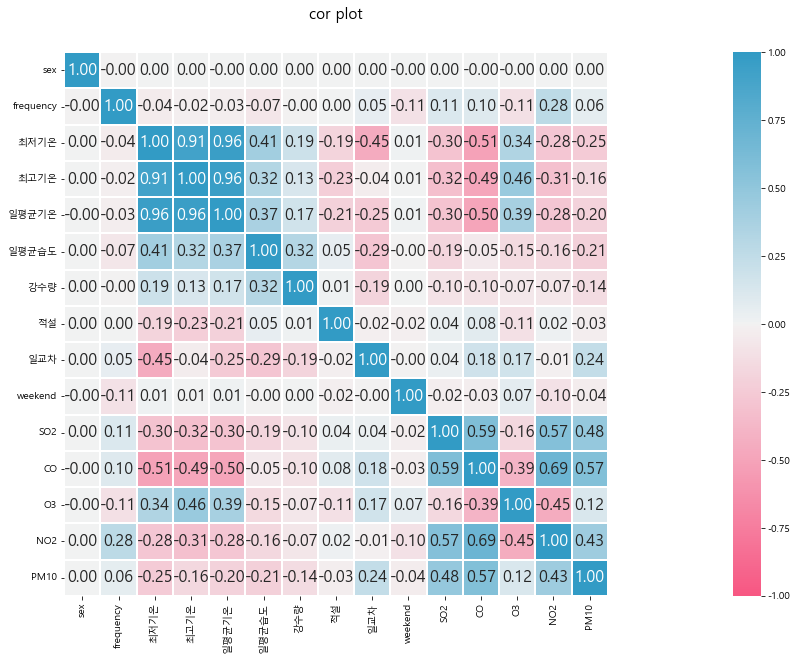

In [156]:
plt_corr(wp.corr())

## 인자분석

In [157]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

chi_square_value,p_value=calculate_bartlett_sphericity(wp[['최저기온', '최고기온', '일평균기온', '일평균습도', '강수량', '적설', '일교차', 'SO2', 'CO', 'O3', 'NO2', 'PM10']])

chi_square_value, p_value

(2019838.710174772, 0.0)

In [158]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all,kmo_model=calculate_kmo(wp[['최저기온', '최고기온', '일평균기온', '일평균습도', '강수량', '적설', '일교차', 'SO2', 'CO', 'O3', 'NO2', 'PM10']])

kmo_model

0.6718807512774085

In [159]:
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(n_factors=20, rotation='varimax')
fa.fit(wp[['최저기온', '최고기온', '일평균기온', '일평균습도', '강수량', '적설', '일교차', 'SO2', 'CO', 'O3', 'NO2', 'PM10']])

ev, v = fa.get_eigenvalues()
ev

array([4.41378108e+00, 1.78623139e+00, 1.72232052e+00, 9.52430428e-01,
       8.92043425e-01, 7.56428218e-01, 5.73433842e-01, 4.47626578e-01,
       2.51128834e-01, 1.79531086e-01, 2.50445927e-02, 1.00805916e-15])

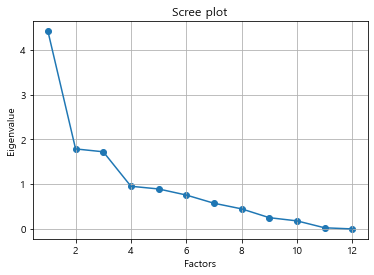

In [160]:
plt.scatter(range(1,wp[['최저기온', '최고기온', '일평균기온', '일평균습도', '강수량', '적설', '일교차', 'SO2', 'CO', 'O3', 'NO2', 'PM10']].shape[1]+1),ev)
plt.plot(range(1,wp[['최저기온', '최고기온', '일평균기온', '일평균습도', '강수량', '적설', '일교차', 'SO2', 'CO', 'O3', 'NO2', 'PM10']].shape[1]+1),ev)
plt.title('Scree plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

5개의 인자 선택

In [161]:
fa = FactorAnalyzer(n_factors=5, rotation="varimax")
fa.fit(wp[['최저기온', '최고기온', '일평균기온', '일평균습도', '강수량', '적설', '일교차', 'SO2', 'CO', 'O3', 'NO2', 'PM10']])

fa.get_factor_variance()

(array([2.7136666 , 2.37512287, 1.40384055, 1.11713529, 1.03506598]),
 array([0.22613888, 0.19792691, 0.11698671, 0.09309461, 0.0862555 ]),
 array([0.22613888, 0.42406579, 0.5410525 , 0.63414711, 0.72040261]))

선택된 인자는 전체 분산 중 72%를 설명한다.

<AxesSubplot:>

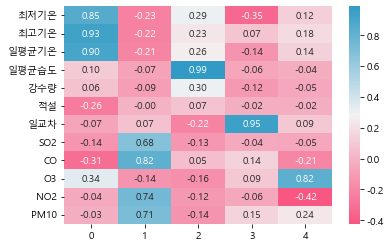

In [162]:
result = pd.DataFrame(fa.loadings_, index=['최저기온', '최고기온', '일평균기온', '일평균습도', '강수량', '적설', '일교차', 'SO2', 'CO', 'O3', 'NO2', 'PM10'])
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
sns.heatmap(result, cmap = cmap, annot=True, fmt ='.2f')

In [163]:
result

,0,1,2,3,4
최저기온,0.851657,-0.226299,0.294566,-0.345946,0.123602
최고기온,0.926852,-0.223503,0.227127,0.074994,0.178400
일평균기온,0.901459,-0.212227,0.264415,-0.140843,0.135621
일평균습도,0.102181,-0.074741,0.987319,-0.060673,-0.035754
강수량,0.063435,-0.093652,0.297150,-0.118098,-0.053120
적설,-0.255607,-0.004092,0.069238,-0.024751,-0.023595
일교차,-0.065301,0.066505,-0.219382,0.947338,0.090328
SO2,-0.136482,0.678103,-0.129995,-0.043704,-0.053625
CO,-0.313581,0.820575,0.045377,0.141631,-0.206679
O3,0.336163,-0.140343,-0.162439,0.094335,0.822296


In [164]:
factor_1 = 0.851657 * wp['최저기온'] + 0.926852 * wp['최고기온'] + 0.901459 * wp['일평균기온'] + 0.102181 * wp['일평균습도'] + 0.063435 * wp['강수량'] + (-0.255607) * wp['적설'] + (-0.065301) * wp['일교차'] + (-0.136482) * wp['SO2'] + (-0.313581) * wp['CO'] + (0.336163) * wp['O3'] + (-0.044514) * wp['NO2'] + (-0.025522) * wp['PM10']
factor_2 = (-0.226299) * wp['최저기온'] + (-0.223503) * wp['최고기온'] + (-0.212227) * wp['일평균기온'] + (-0.074741) * wp['일평균습도'] + (-0.093652) * wp['강수량'] + (-0.004092) * wp['적설'] + 0.066505 * wp['일교차'] + 0.678103 * wp['SO2'] + 0.820575 * wp['CO'] + (-0.140343) * wp['O3'] + (0.740756) * wp['NO2'] + (0.713119) * wp['PM10']
factor_3 = 0.294566 * wp['최저기온'] + 0.227127 * wp['최고기온'] + 0.264415 * wp['일평균기온'] + (0.987319) * wp['일평균습도'] + 0.297150 * wp['강수량'] + (0.069238) * wp['적설'] + (-0.219382) * wp['일교차'] + (-0.129995) * wp['SO2'] + (0.045377) * wp['CO'] + (-0.162439) * wp['O3'] + (-0.119801) * wp['NO2'] + (-0.140903) * wp['PM10']
factor_4 = (-0.345946) * wp['최저기온'] + 0.074994 * wp['최고기온'] + (-0.140843) * wp['일평균기온'] + (-0.060673) * wp['일평균습도'] + (-0.118098) * wp['강수량'] + (-0.024751) * wp['적설'] + (0.947338) * wp['일교차'] + (-0.043704) * wp['SO2'] + (0.141631) * wp['CO'] + (0.094335) * wp['O3'] + (-0.056978) * wp['NO2'] + (0.148965) * wp['PM10']
factor_5 = 0.123602 * wp['최저기온'] + 0.178400 * wp['최고기온'] + (0.135621) * wp['일평균기온'] + (-0.035754) * wp['일평균습도'] + (-0.053120) * wp['강수량'] + (-0.023595) * wp['적설'] + (0.090328) * wp['일교차'] + (-0.053625) * wp['SO2'] + (-0.206679) * wp['CO'] + (0.822296) * wp['O3'] + (-0.423399) * wp['NO2'] + (0.236058) * wp['PM10']

In [165]:
wp_fa = pd.concat([wp[['yyyymmdd', 'area', 'sex', 'frequency', 'season', 'weekend']], 
                   pd.DataFrame({'fac1':factor_1, 'fac2':factor_2, 'fac3': factor_3, 'fac4':factor_4, 'fac5':factor_5})], axis=1)
wp_fa

,yyyymmdd,area,sex,frequency,season,weekend,fac1,fac2,fac3,fac4,fac5
0,2012-01-01,강원,1,3,겨울,1,-9.308374,58.211948,49.454215,32.861604,16.541662
1,2012-01-01,강원,2,3,겨울,1,-9.308374,58.211948,49.454215,32.861604,16.541662
2,2012-01-01,경기,1,4,겨울,1,-11.475411,61.356497,46.854884,26.533693,16.562992
3,2012-01-01,경기,2,5,겨울,1,-11.475411,61.356497,46.854884,26.533693,16.562992
4,2012-01-01,경남,1,2,겨울,1,4.120421,41.614525,42.129325,25.411928,14.601078
...,...,...,...,...,...,...,...,...,...,...,...
49669,2015-12-31,제주,2,0,겨울,0,23.438268,45.369664,46.802939,15.250116,20.012601
49670,2015-12-31,충남,1,0,겨울,0,5.190462,34.314226,63.796867,20.928584,11.463687
49671,2015-12-31,충남,2,0,겨울,0,5.190462,34.314226,63.796867,20.928584,11.463687
49672,2015-12-31,충북,1,1,겨울,0,3.677361,41.694270,57.741190,22.398997,13.655097


In [204]:
wp_fa.to_excel('wp_fa.xlsx', index=False, encoding='utf-8')

## 회귀분석

### 1) sklearn linear regression

In [166]:
wp_fa_ohe = pd.get_dummies(wp_fa, columns = ['area', 'season', 'sex'])
wp_fa_ohe.head(2)

,yyyymmdd,frequency,weekend,fac1,fac2,fac3,fac4,fac5,area_강원,area_경기,...,area_전북,area_제주,area_충남,area_충북,season_가을,season_겨울,season_봄,season_여름,sex_1,sex_2
0,2012-01-01,3,1,-9.308374,58.211948,49.454215,32.861604,16.541662,1,0,...,0,0,0,0,0,1,0,0,1,0
1,2012-01-01,3,1,-9.308374,58.211948,49.454215,32.861604,16.541662,1,0,...,0,0,0,0,0,1,0,0,0,1


In [167]:
df_train = wp_fa_ohe.drop(columns = ['frequency']) 
target_train = wp_fa_ohe['frequency'] 

X_train, X_val, y_train, y_val = train_test_split(df_train, target_train, test_size=0.2, random_state=42, shuffle=True) 

In [168]:
x_variables = [i for i in df_train.columns] 
x_variables.remove('yyyymmdd')

In [169]:
lin_model = LinearRegression() 
lin_model.fit(X_train[x_variables], y_train)      
lin_r_sq = lin_model.score(X_train[x_variables], y_train)
 
print(lin_r_sq)
print(lin_model.intercept_)
print(lin_model.coef_)

0.4490539775223409
-8941861348.862091
[-3.85926441e-01 -3.35678148e-02 -3.83509679e-02  5.74230988e-03
 -7.84024233e-03  1.25526213e-01  1.03430730e+10  1.03430730e+10
  1.03430730e+10  1.03430730e+10  1.03430730e+10  1.03430730e+10
  1.03430730e+10  1.03430730e+10  1.03430730e+10  1.03430730e+10
  1.03430730e+10  1.03430730e+10  1.03430730e+10  1.03430730e+10
  1.03430730e+10  1.03430730e+10  1.03430730e+10 -2.79169540e+09
 -2.79169540e+09 -2.79169540e+09 -2.79169540e+09  1.39048377e+09
  1.39048377e+09]


In [227]:
lin_y_pred = lin_model.predict(X_val[x_variables]) 
print('mse:',mean_squared_error(lin_y_pred, y_val))

mse: 1.5626441776005067


In [232]:
print('rmse:',mean_squared_error(lin_y_pred, y_val, squared = False))

rmse: 1.2500576697098844


### 2) statsmodels.ols

In [171]:
df_train_2 = wp_fa.drop(columns = ['frequency']) 
target_train_2 = wp_fa['frequency'] 

X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(df_train_2, target_train_2, test_size=0.2, random_state=42, shuffle=True) 

In [172]:
formula_1 = 'frequency ~ C(area) + C(sex) + C(season) + C(weekend) + fac1 + fac2 + fac3 + fac4 + fac5 +'
formula_2 = 'fac1:fac2 + fac1:fac3 + fac1:fac4 +fac1:fac5 + fac2:fac3 + fac2:fac4 + fac2:fac5 + fac3:fac4 + fac3:fac5 + fac4:fac5 +'
formula_3 = 'fac1:fac2:fac3 + fac1:fac2:fac4 + fac1:fac2:fac5 + fac1:fac3:fac4 + fac1:fac3:fac5 + fac1:fac4:fac5 +'
formula_4 = 'fac2:fac3:fac4 + fac2:fac3:fac5 + fac2:fac4:fac5 + fac3:fac4:fac5 +'
formula_5 = 'fac1:fac2:fac3:fac4 + fac1:fac2:fac3:fac5 + fac1:fac2:fac4:fac5 + fac1:fac3:fac4:fac5 + fac2:fac3:fac4:fac5 + fac1:fac2:fac3:fac4:fac5'
formula = formula_1 + formula_2 + formula_3 + formula_4 + formula_5
ols_model = ols(formula = formula, data = pd.concat([X_train_2, y_train_2], axis=1)).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              frequency   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     623.7
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        01:41:56   Log-Likelihood:                -64885.
No. Observations:               39739   AIC:                         1.299e+05
Df Residuals:                   39686   BIC:                         1.303e+05
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.2501      0.304      0.822      0.411      -0.346       0.846
C(area)[T.경기]                3.5200      0.040     87.539      0.000       3.441       3.599
C(area)[T.경남]                1.0229      0.040     25.349      0.000       0.944       1.102
C(area)[T.경북]                0.9172      0.038     23.866      0.000       0.842       0.993
C(area)[T.광주]               -0.2519      0.044     -5.661      0.000      -0.339      -0.165
C(area)[T.대구]                0.1477      0.046      3.217      0.001       0.058       0.238
C(area)[T.대전]               -0.3274      0.042     -7.885      0.000      -0.409      -0.246
C(area)[T.부산]                0.7460      0.049     15.243      0.000       0.650       0.842
C(area)[T.서울]                2.5761      0.048     54.206      0.000       2.483       2.669
C(area)[T.세종]               -0.9558      0.041    -23.360      0.000      -1.036      -0.876
C(area)[T.울산]               -0.5335      0.045    -11.908      0.000      -0.621      -0.446
C(area)[T.인천]                0.0506      0.042      1.215      0.224      -0.031       0.132
C(area)[T.전남]                0.5687      0.040     14.180      0.000       0.490       0.647
C(area)[T.전북]                0.2799      0.038      7.270      0.000       0.204       0.355
C(area)[T.제주]               -0.7364      0.046    -15.887      0.000      -0.827      -0.646
C(area)[T.충남]                0.1007      0.040      2.548      0.011       0.023       0.178
C(area)[T.충북]               -0.0249      0.040     -0.625      0.532      -0.103       0.053
C(sex)[T.2]                 -0.0068      0.012     -0.550      0.582      -0.031       0.018
C(season)[T.겨울]              0.0197      0.029      0.685      0.493      -0.037       0.076
C(season)[T.봄]               0.0119      0.020      0.587      0.557      -0.028       0.052
C(season)[T.여름]             -0.0118      0.027     -0.430      0.667      -0.065       0.042
C(weekend)[T.1]             -0.3875      0.014    -28.019      0.000      -0.415      -0.360
fac1                        -0.0381      0.033     -1.165      0.244      -0.102       0.026
fac2                        -0.0348      0.045     -0.773      0.440      -0.123       0.054
fac3                         0.0165      0.005      3.303      0.001       0.007       0.026
fac4                        -0.0073      0.017     -0.426      0.670      -0.041       0.026
fac5                         0.2308      0.133      1.742      0.082      -0.029       0.491
fac1:fac2                   -0.0002      0.000     -0.764      0.445      -0.001       0.000
fac1:fac3                -5.338e-05      0.000     -0.212      0.832      -0.001       0.000
fac1:fac4                -4.563e-05      0.001     -0.055      0.956      -0.002       0.002
fac1:fac5     

In [173]:
ols_model_2 = ols('frequency ~ C(area) + C(sex) + C(season) + C(weekend) + fac3 + fac5 + fac2:fac5 + fac2:fac3:fac5',
               data = pd.concat([X_train_2, y_train_2], axis=1)).fit()
ols_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              frequency   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     1294.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        01:41:58   Log-Likelihood:                -64911.
No. Observations:               39739   AIC:                         1.299e+05
Df Residuals:                   39713   BIC:                         1.301e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.1096      0.052     21.417      0.000       1.008       1.211
C(area)[T.경기]       3.4964      0.036     96.022      0.000       3.425       3.568
C(area)[T.경남]       0.9819      0.037     26.873      0.000       0.910       1.054
C(area)[T.경북]       0.8886      0.036     24.381      0.000       0.817       0.960
C(area)[T.광주]      -0.2997      0.037     -8.211      0.000      -0.371      -0.228
C(area)[T.대구]       0.0906      0.037      2.457      0.014       0.018       0.163
C(area)[T.대전]      -0.3582      0.036     -9.862      0.000      -0.429      -0.287
C(area)[T.부산]       0.6989      0.036     19.172      0.000       0.627       0.770
C(area)[T.서울]       2.5141      0.037     68.697      0.000       2.442       2.586
C(area)[T.세종]      -0.9815      0.036    -26.984      0.000      -1.053      -0.910
C(area)[T.울산]      -0.5817      0.036    -16.016      0.000      -0.653      -0.511
C(area)[T.인천]       0.0202      0.036      0.557      0.577      -0.051       0.091
C(area)[T.전남]       0.5381      0.037     14.730      0.000       0.467       0.610
C(area)[T.전북]       0.2628      0.037      7.193      0.000       0.191       0.334
C(area)[T.제주]      -0.7736      0.037    -21.141      0.000      -0.845      -0.702
C(area)[T.충남]       0.0770      0.036      2.126      0.034       0.006       0.148
C(area)[T.충북]      -0.0547      0.036     -1.513      0.130      -0.126       0.016
C(sex)[T.2]        -0.0068      0.012     -0.548      0.584      -0.031       0.018
C(season)[T.겨울]     0.0495      0.023      2.120      0.034       0.004       0.095
C(season)[T.봄]      0.0087      0.019      0.460      0.645      -0.028       0.046
C(season)[T.여름]    -0.0206      0.022     -0.943      0.345      -0.063       0.022
C(weekend)[T.1]    -0.3867      0.014    -28.047      0.000      -0.414      -0.360
fac3               -0.0005      0.000     -0.981      0.326      -0.001       0.000
fac5                0.0050      0.002      2.066      0.039       0.000       0.010
fac2:fac5        8.293e-06   1.26e-05      0.656      0.512   -1.65e-05    3.31e-05
fac2:fac3:fac5  -7.438e-07   3.73e-07     -1.996      0.046   -1.47e-06   -1.35e-08
==============================================================================
Omnibus:                     6492.931   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17208.886
Skew:                           0.898   Prob(JB):                         0.00
Kurtosis:                       5.678   Cond. No.                     6.04e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.04e+05. This might indicate that the

최종

In [174]:
ols_model_3 = ols('frequency ~ C(area) + C(sex) + C(season) + C(weekend) +  fac5 + fac2:fac3:fac5',
               data = pd.concat([X_train_2, y_train_2], axis=1))
result = ols_model_3.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              frequency   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     1407.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        01:42:00   Log-Likelihood:                -64912.
No. Observations:               39739   AIC:                         1.299e+05
Df Residuals:                   39715   BIC:                         1.301e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.0619      0.034     31.136      0.000       0.995       1.129
C(area)[T.경기]       3.4950      0.036     96.031      0.000       3.424       3.566
C(area)[T.경남]       0.9806      0.036     26.990      0.000       0.909       1.052
C(area)[T.경북]       0.8884      0.036     24.468      0.000       0.817       0.960
C(area)[T.광주]      -0.3032      0.036     -8.335      0.000      -0.375      -0.232
C(area)[T.대구]       0.0905      0.037      2.476      0.013       0.019       0.162
C(area)[T.대전]      -0.3607      0.036     -9.947      0.000      -0.432      -0.290
C(area)[T.부산]       0.6962      0.036     19.177      0.000       0.625       0.767
C(area)[T.서울]       2.5154      0.036     68.990      0.000       2.444       2.587
C(area)[T.세종]      -0.9848      0.036    -27.150      0.000      -1.056      -0.914
C(area)[T.울산]      -0.5841      0.036    -16.124      0.000      -0.655      -0.513
C(area)[T.인천]       0.0170      0.036      0.470      0.638      -0.054       0.088
C(area)[T.전남]       0.5339      0.036     14.680      0.000       0.463       0.605
C(area)[T.전북]       0.2593      0.036      7.118      0.000       0.188       0.331
C(area)[T.제주]      -0.7789      0.036    -21.445      0.000      -0.850      -0.708
C(area)[T.충남]       0.0743      0.036      2.056      0.040       0.003       0.145
C(area)[T.충북]      -0.0554      0.036     -1.533      0.125      -0.126       0.015
C(sex)[T.2]        -0.0069      0.012     -0.551      0.581      -0.031       0.018
C(season)[T.겨울]     0.0663      0.019      3.518      0.000       0.029       0.103
C(season)[T.봄]      0.0142      0.018      0.785      0.433      -0.021       0.050
C(season)[T.여름]    -0.0338      0.019     -1.790      0.073      -0.071       0.003
C(weekend)[T.1]    -0.3869      0.014    -28.061      0.000      -0.414      -0.360
fac5                0.0064      0.002      3.997      0.000       0.003       0.010
fac2:fac3:fac5  -8.479e-07   3.47e-07     -2.446      0.014   -1.53e-06   -1.68e-07
==============================================================================
Omnibus:                     6492.358   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17207.500
Skew:                           0.898   Prob(JB):                         0.00
Kurtosis:                       5.678   Cond. No.                     6.02e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.02e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [175]:
y_new = result.predict(X_val_2)
print('mse:', mean_squared_error(y_new, y_val_2))

mse: 1.5612479585752033


### 3) Ridge & Lasso

In [233]:
alphas = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train[x_variables], y_train)
    ridge_y_pred = ridge.predict(X_val[x_variables])
    
    ridge_r_sq = ridge.score(X_train[x_variables], y_train)
 
    print("****************")
    print("alpha: ",alpha)
    print("r^2: ", ridge_r_sq)
    print("intercept: ",ridge.intercept_)
    print("coef_: ", ridge.coef_)
    print("MSE: ", mean_squared_error(ridge_y_pred, y_val))
    print("RMSE: ", mean_squared_error(ridge_y_pred, y_val, squared = False))

****************
alpha:  100
r^2:  0.4482656082420663
intercept:  1.4481882953101097
coef_:  [-3.80920040e-01 -1.62868365e-02 -1.80615716e-02  2.76974835e-03
 -1.88251837e-03  6.07292770e-02 -4.02746928e-01  2.97194354e+00
  5.75116320e-01  4.71563992e-01 -6.40628864e-01 -2.59315947e-01
 -7.13470525e-01  3.26495195e-01  2.06399972e+00 -1.31394822e+00
 -9.11896447e-01 -3.53774314e-01  1.47037001e-01 -1.33629090e-01
 -1.09052557e+00 -3.04679709e-01 -4.31540159e-01 -4.30945070e-03
 -5.30963327e-03 -9.52361994e-03  1.91427039e-02  3.32653908e-03
 -3.32653908e-03]
MSE:  1.564709384749492
RMSE:  1.2508834417120933
****************
alpha:  10
r^2:  0.44904534714282607
intercept:  1.4283767699719607
coef_:  [-0.38541036 -0.03153659 -0.03596554  0.00539703 -0.0071433   0.11790634
 -0.41634313  3.08868375  0.60223188  0.49633995 -0.66688131 -0.26619446
 -0.74459668  0.33614367  2.14993762 -1.3682004  -0.94744917 -0.36851445
  0.14962794 -0.14095433 -1.14138895 -0.31858738 -0.44385456 -0.00740659

In [234]:
alphas = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train[x_variables], y_train)
    lasso_y_pred = lasso.predict(X_val[x_variables])
    
    lasso_r_sq = lasso.score(X_train[x_variables], y_train)
 
    print("****************")
    print("alpha: ",alpha)
    print("r^2: ", lasso_r_sq)
    print("intercept: ",lasso.intercept_)
    print("coef_: ", lasso.coef_)
    print("MSE: ", mean_squared_error(lasso_y_pred, y_val))
    print("RMSE: ", mean_squared_error(lasso_y_pred, y_val, squared = False))

****************
alpha:  100
r^2:  0.0
intercept:  1.4212989758172072
coef_:  [-0. -0.  0. -0.  0.  0. -0.  0.  0.  0. -0. -0. -0.  0.  0. -0. -0. -0.
  0. -0. -0. -0. -0. -0.  0.  0. -0.  0. -0.]
MSE:  2.839158983294186
RMSE:  1.6849804103591786
****************
alpha:  10
r^2:  0.0
intercept:  1.4212989758172072
coef_:  [-0. -0.  0. -0.  0.  0. -0.  0.  0.  0. -0. -0. -0.  0.  0. -0. -0. -0.
  0. -0. -0. -0. -0. -0.  0.  0. -0.  0. -0.]
MSE:  2.839158983294186
RMSE:  1.6849804103591786
****************
alpha:  1
r^2:  0.005310697027296252
intercept:  1.5959589903346638
coef_:  [-0.         -0.          0.00126361 -0.00300021  0.          0.
 -0.          0.          0.          0.         -0.         -0.
 -0.          0.          0.         -0.         -0.         -0.
  0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.          0.          0.         -0.        ]
MSE:  2.8284847303774323
RMSE:  1.6818099566768632
****************
alpha:  0.1
r^2:  0.2011

### 4) RandomForest

In [237]:
mse = []
nTree = range(10, 300, 10)
min_mse = 10000
tree = 0

for n in tqdm(nTree):
    rfr = RandomForestRegressor(n_estimators=n, max_depth=6)
    rfr.fit(X_train[x_variables], y_train)
    rf_pred = rfr.predict(X_val[x_variables])
    rf_mse = mean_squared_error(y_val, rf_pred)
    mse.append(rf_mse)
    if rf_mse < min_mse:
        min_mse = rf_mse
        tree = n

print(mse)
print(min_mse)
print(tree)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [15:00<00:00, 31.04s/it]

[1.638302299931191, 1.6370580366341942, 1.6418270869589882, 1.6388887033970092, 1.6377615642806602, 1.6403990017945675, 1.6404750612314511, 1.636613416622563, 1.6390143243952016, 1.6388735078227963, 1.6371793091933162, 1.6383256084613373, 1.6396353203914429, 1.639595581127482, 1.6414824691115018, 1.6368393096243141, 1.6387639065273043, 1.6391058758182886, 1.6411080822581399, 1.638374979801635, 1.638401881887676, 1.6392761851001523, 1.6385872827437853, 1.638580407605962, 1.637614734217604, 1.6373951516340972, 1.6378088325840712, 1.6383723743329388, 1.6369725734257765]
1.636613416622563
80


In [238]:
print('min rmse: ', np.sqrt(min_mse))

min rmse:  1.2793019255135056


### 5) GB

In [239]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train[x_variables], y_train)
gbr_pred = gbr.predict(X_val[x_variables])
gbr_mse = mean_squared_error(y_val, gbr_pred)
print("r^2: ",gbr.score(X_train[x_variables], y_train))
print("mse: ",gbr_mse)
print("rmse: ", np.sqrt(gbr_mse))

r^2:  0.4623854779874378
mse:  1.5505462700723274
rmse:  1.2452093278129293


# 3. 지역, 성별

In [176]:
date_list = social_data['date'].unique()
diff = []
for i in range(0, len(date_list)-1):
    delta = date_list[i+1] - date_list[i]
    delta = delta.astype('timedelta64[D]') / np.timedelta64(1, 'D')
    diff.append(delta)
diff.append(92)

In [177]:
df = pd.DataFrame()
for i in tqdm(range(len(diff))):
    for j in range(0, int(diff[i])):
        temp = social_data[social_data['date']==date_list[i]]
        temp['date'] = temp['date']+np.timedelta64(j, 'D')
        df = pd.concat([df,temp])

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:02<00:00,  3.14s/it]


In [178]:
bh_social = pd.merge(back_hospital, df, left_on=['yyyymmdd','area'], right_on=['date','지역'], how='left').drop(columns=['date','지역'])
bh_social

,yyyymmdd,area,sex,frequency,간호사,고령인구비율,구급인력,구급차,병원,비만율,...,신경외과,약국,요양병원,응급의학과,종합병원,흉부외과,흡연율,병실수,보건시설,공장수
0,2012-01-01,강원,1,3,3983,15.7,566,871,49,26.7,...,77,629,48,34,26,30,26.2,20959,245,2877
1,2012-01-01,강원,2,3,3983,15.7,566,871,49,26.7,...,77,629,48,34,26,30,26.2,20959,245,2877
2,2012-01-01,경기,1,4,20380,9.4,1421,1796,281,24.6,...,411,4333,442,198,100,169,24.5,123168,334,54213
3,2012-01-01,경기,2,5,20380,9.4,1421,1796,281,24.6,...,411,4333,442,198,100,169,24.5,123168,334,54213
4,2012-01-01,경남,1,2,7548,12.5,731,515,140,22.5,...,150,1137,172,47,46,52,24.1,56963,410,15305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49669,2015-12-31,제주,2,0,2231,13.8,208,71,7,28.5,...,32,252,16,40,14,17,21.3,5628,63,675
49670,2015-12-31,충남,1,0,4424,16.4,639,371,52,26.4,...,79,860,148,49,22,38,23.4,29816,400,8477
49671,2015-12-31,충남,2,0,4424,16.4,639,371,52,26.4,...,79,860,148,49,22,38,23.4,29816,400,8477
49672,2015-12-31,충북,1,1,3726,14.8,443,284,40,26.5,...,77,633,80,32,22,29,22.2,21007,266,7167


In [179]:
bh_social['발병여부'] = 0
bh_social.loc[bh_social['frequency']>0,'발병여부'] = 1

## 성별

In [180]:
chi = chi2_contingency(pd.crosstab(bh_social['sex'], bh_social['발병여부']))
print('Chi2 Statistic: {}, p-value: {}'.format(chi[0], chi[1]))

Chi2 Statistic: 0.9744234666763167, p-value: 0.3235794513073717


성별만으로 발병 여부에 영향을 주지 않는 것으로 파악됨.

## 지역
### 1) 의료 인프라

In [181]:
def split_and_scaling(df, col, y):
    X_train, X_val, y_train, y_val = train_test_split(df[col], df[y], test_size=0.2, random_state=42, shuffle=True) 
    X_train.reset_index(inplace=True, drop=True); y_train = y_train.reset_index(drop=True)
    X_val.reset_index(inplace=True,drop=True); y_val = y_val.reset_index(drop=True)
    
    infra_scaler = RobustScaler()
    infra_scaler.fit(X_train[col])
    X_train[col] = pd.DataFrame(infra_scaler.transform(X_train[col]), columns=col)
    X_val[col] = pd.DataFrame(infra_scaler.transform(X_val[col]), columns=col)
    return X_train, X_val, y_train, y_val

In [182]:
def logistic_regression(df, col, y):
    x_train, x_val, y_train, y_val = split_and_scaling(df, col, y)
    logistic_model = LogisticRegression()
    logistic_model.fit(x_train[col], y_train)
    
    train_score = logistic_model.score(x_train[col], y_train)
    val_score = logistic_model.score(x_val[col], y_val)
    coef = logistic_model.coef_[0]
    return pd.DataFrame({'train_score':train_score, 'val_score':val_score, 'coef':coef}, index=col)

In [183]:
infra_col = ['간호사', '구급인력', '구급차', '병원', '상급종합병원', '신경외과', '약국', '요양병원', '응급의학과', '종합병원',
            '흉부외과', '병실수', '보건시설']

In [185]:
area_layer = [i for i in bh_social['area'].unique()]
area_log = pd.DataFrame()
for i in area_layer:
    temp = bh_social[bh_social['area']==i]
    result_df = logistic_regression(temp, infra_col, '발병여부')
    result_df['area'] = i
    area_log = pd.concat([area_log, result_df])

In [186]:
area_log

,train_score,val_score,coef,area
간호사,0.621309,0.647863,-0.010200,강원
구급인력,0.621309,0.647863,-0.010391,강원
구급차,0.621309,0.647863,0.031506,강원
병원,0.621309,0.647863,0.007767,강원
상급종합병원,0.621309,0.647863,0.005604,강원
...,...,...,...,...
응급의학과,0.608045,0.610256,-0.154024,충북
종합병원,0.608045,0.610256,-0.045923,충북
흉부외과,0.608045,0.610256,0.078462,충북
병실수,0.608045,0.610256,0.023100,충북


In [187]:
def linear_regression(df, col, y):
    x_train, x_val, y_train, y_val = split_and_scaling(df, col, y)
    linear_model = LinearRegression()
    linear_model.fit(x_train[col], y_train)
    
    y_pred = linear_model.predict(x_val[col]) 
    mse = mean_squared_error(y_pred, y_val, squared = False)
    lin_r_sq = linear_model.score(x_train[col], y_train)
    coef = lin_model.coef_
    
    return pd.DataFrame({'lin_r_sq':lin_r_sq, 'mse':mse}, index=df['area'].unique())

In [188]:
area_lin = pd.DataFrame()
for i in area_layer:
    temp = bh_social[bh_social['area']==i]
    result_df = linear_regression(temp, infra_col, 'frequency')
    area_lin = pd.concat([area_lin, result_df])

In [189]:
area_lin

,lin_r_sq,mse
강원,0.003966,1.122877
경기,0.003908,2.210145
경남,0.002142,1.415474
경북,0.004945,1.452202
광주,-0.001125,0.898249
대구,0.003871,1.131442
대전,0.002819,0.753452
부산,0.004034,1.391241
서울,0.002289,2.047827
세종,0.005543,0.200479


발병여부와는 관련 있으나, 환자수와는 관련이 없다.

In [ ]:
area_log.to_excel("infra_logistic_result.xlsx", encoding='utf-8')

### 2) 인구 사회적 요인

In [190]:
social_col = ['고령인구비율', '비만율', '흡연율', '공장수']
social_log = pd.DataFrame()
for i in area_layer:
    temp = bh_social[bh_social['area']==i]
    result_df = logistic_regression(temp, social_col, '발병여부')
    result_df['area'] = i
    social_log = pd.concat([social_log, result_df])

In [191]:
social_log

,train_score,val_score,coef,area
고령인구비율,0.621309,0.647863,-0.006111,강원
비만율,0.621309,0.647863,-0.031475,강원
흡연율,0.621309,0.647863,-0.067374,강원
공장수,0.621309,0.647863,-0.033440,강원
고령인구비율,0.985879,0.989744,-0.065332,경기
...,...,...,...,...
공장수,0.652118,0.659829,-0.088063,충남
고령인구비율,0.608045,0.610256,-0.035467,충북
비만율,0.608045,0.610256,0.085590,충북
흡연율,0.608045,0.610256,0.033985,충북


In [192]:
social_lin = pd.DataFrame()
for i in area_layer:
    temp = bh_social[bh_social['area']==i]
    result_df = linear_regression(temp, social_col, 'frequency')
    social_lin = pd.concat([social_lin, result_df])

In [193]:
social_lin

,lin_r_sq,mse
강원,0.003496,1.121880
경기,0.001247,2.217435
경남,0.000747,1.411948
경북,0.000256,1.447247
광주,0.000516,0.894024
대구,0.004218,1.132135
대전,0.001732,0.752467
부산,0.001665,1.391932
서울,0.001477,2.048696
세종,0.004853,0.200430


발병여부와는 관련이 있으나 환자수와는 관련이 없다.

In [ ]:
social_log.to_excel('social_logistic_result.xlsx', encoding='utf-8')

In [194]:
infra_score = area_log.groupby('area')[['coef']].sum().reset_index()
social_score = social_log.groupby('area')[['coef']].sum().reset_index()

In [195]:
infra_score.rename(columns={'coef':'infra_score'}, inplace=True)
social_score.rename(columns={'coef':'social_score'}, inplace=True)

In [196]:
score = pd.merge(infra_score, social_score, on='area', how='inner')

#### score + statsmodels.ols

In [197]:
wp_fa_score = pd.merge(wp_fa, score, on='area', how='left')

In [198]:
df_train_3 = wp_fa_score.drop(columns = ['frequency']) 
target_train_3 = wp_fa_score['frequency'] 

X_train_3, X_val_3, y_train_3, y_val_3 = train_test_split(df_train_3, target_train_3, test_size=0.2, random_state=42, shuffle=True) 

In [199]:
formula_1 = 'frequency ~ C(area) + C(sex) + C(season) + C(weekend) + infra_score + social_score +fac1 + fac2 + fac3 + fac4 + fac5 +'
formula_2 = 'fac1:fac2 + fac1:fac3 + fac1:fac4 +fac1:fac5 + fac2:fac3 + fac2:fac4 + fac2:fac5 + fac3:fac4 + fac3:fac5 + fac4:fac5 +'
formula_3 = 'fac1:fac2:fac3 + fac1:fac2:fac4 + fac1:fac2:fac5 + fac1:fac3:fac4 + fac1:fac3:fac5 + fac1:fac4:fac5 +'
formula_4 = 'fac2:fac3:fac4 + fac2:fac3:fac5 + fac2:fac4:fac5 + fac3:fac4:fac5 +'
formula_5 = 'fac1:fac2:fac3:fac4 + fac1:fac2:fac3:fac5 + fac1:fac2:fac4:fac5 + fac1:fac3:fac4:fac5 + fac2:fac3:fac4:fac5 + fac1:fac2:fac3:fac4:fac5'
formula = formula_1 + formula_2 + formula_3 + formula_4 + formula_5
ols_model = ols(formula = formula, data = pd.concat([X_train_3, y_train_3], axis=1)).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              frequency   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     623.7
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        01:46:09   Log-Likelihood:                -64885.
No. Observations:               39739   AIC:                         1.299e+05
Df Residuals:                   39686   BIC:                         1.303e+05
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.4967      0.292      1.698      0.089      -0.077       1.070
C(area)[T.경기]                2.7543      0.034     81.503      0.000       2.688       2.821
C(area)[T.경남]                1.3515      0.037     36.092      0.000       1.278       1.425
C(area)[T.경북]                0.5086      0.032     15.672      0.000       0.445       0.572
C(area)[T.광주]               -0.3978      0.035    -11.231      0.000      -0.467      -0.328
C(area)[T.대구]                0.4449      0.028     15.940      0.000       0.390       0.500
C(area)[T.대전]               -0.2380      0.039     -6.163      0.000      -0.314      -0.162
C(area)[T.부산]                0.6407      0.045     14.123      0.000       0.552       0.730
C(area)[T.서울]                2.1694      0.042     51.826      0.000       2.087       2.251
C(area)[T.세종]               -1.0173      0.051    -19.980      0.000      -1.117      -0.918
C(area)[T.울산]               -0.3269      0.046     -7.157      0.000      -0.416      -0.237
C(area)[T.인천]               -0.6155      0.031    -20.077      0.000      -0.676      -0.555
C(area)[T.전남]                0.0440      0.031      1.416      0.157      -0.017       0.105
C(area)[T.전북]               -0.1484      0.033     -4.462      0.000      -0.214      -0.083
C(area)[T.제주]               -0.8397      0.041    -20.492      0.000      -0.920      -0.759
C(area)[T.충남]                0.0972      0.033      2.932      0.003       0.032       0.162
C(area)[T.충북]               -0.1470      0.031     -4.788      0.000      -0.207      -0.087
C(sex)[T.2]                 -0.0068      0.012     -0.550      0.582      -0.031       0.018
C(season)[T.겨울]              0.0197      0.029      0.685      0.493      -0.037       0.076
C(season)[T.봄]               0.0119      0.020      0.587      0.557      -0.028       0.052
C(season)[T.여름]             -0.0118      0.027     -0.430      0.667      -0.065       0.042
C(weekend)[T.1]             -0.3875      0.014    -28.019      0.000      -0.415      -0.360
infra_score                 -1.1283      0.052    -21.511      0.000      -1.231      -1.025
social_score                -0.8416      0.019    -45.174      0.000      -0.878      -0.805
fac1                        -0.0381      0.033     -1.165      0.244      -0.102       0.026
fac2                        -0.0348      0.045     -0.773      0.440      -0.123       0.054
fac3                         0.0165      0.005      3.303      0.001       0.007       0.026
fac4                        -0.0073      0.017     -0.426      0.670      -0.041       0.026
fac5                         0.2308      0.133      1.742      0.082      -0.029       0.491
fac1:fac2                   -0.0002      0.000     -0.764      0.445      -0.001       0.000
fac1:fac3     

In [200]:
formula = 'frequency ~ C(area) + C(sex) + C(season) + C(weekend) + infra_score + social_score + fac3 + fac5 + fac2:fac5 + fac2:fac4:fac5'
ols_model_2 = ols(formula =formula , data = pd.concat([X_train_3, y_train_3], axis=1)).fit()
ols_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              frequency   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     1294.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        01:46:19   Log-Likelihood:                -64912.
No. Observations:               39739   AIC:                         1.299e+05
Df Residuals:                   39713   BIC:                         1.301e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.3257      0.045     29.452      0.000       1.238       1.414
C(area)[T.경기]       2.7532      0.030     91.789      0.000       2.694       2.812
C(area)[T.경남]       1.3219      0.034     38.765      0.000       1.255       1.389
C(area)[T.경북]       0.5440      0.026     20.887      0.000       0.493       0.595
C(area)[T.광주]      -0.4012      0.029    -13.715      0.000      -0.458      -0.344
C(area)[T.대구]       0.4724      0.021     22.780      0.000       0.432       0.513
C(area)[T.대전]      -0.2555      0.034     -7.480      0.000      -0.322      -0.189
C(area)[T.부산]       0.6119      0.034     18.101      0.000       0.546       0.678
C(area)[T.서울]       2.1341      0.032     66.798      0.000       2.071       2.197
C(area)[T.세종]      -1.0756      0.043    -24.865      0.000      -1.160      -0.991
C(area)[T.울산]      -0.3756      0.037    -10.178      0.000      -0.448      -0.303
C(area)[T.인천]      -0.5759      0.025    -23.424      0.000      -0.624      -0.528
C(area)[T.전남]       0.0907      0.025      3.657      0.000       0.042       0.139
C(area)[T.전북]      -0.0712      0.024     -3.021      0.003      -0.117      -0.025
C(area)[T.제주]      -0.8507      0.033    -26.158      0.000      -0.914      -0.787
C(area)[T.충남]       0.1046      0.031      3.403      0.001       0.044       0.165
C(area)[T.충북]      -0.1124      0.026     -4.395      0.000      -0.163      -0.062
C(sex)[T.2]        -0.0068      0.012     -0.547      0.584      -0.031       0.018
C(season)[T.겨울]     0.0455      0.023      1.948      0.051      -0.000       0.091
C(season)[T.봄]      0.0084      0.019      0.444      0.657      -0.029       0.045
C(season)[T.여름]    -0.0158      0.022     -0.733      0.463      -0.058       0.026
C(weekend)[T.1]    -0.3864      0.014    -28.026      0.000      -0.413      -0.359
infra_score        -1.0042      0.036    -27.780      0.000      -1.075      -0.933
social_score       -0.8747      0.016    -56.398      0.000      -0.905      -0.844
fac3               -0.0006      0.000     -1.271      0.204      -0.002       0.000
fac5                0.0044      0.002      1.753      0.080      -0.001       0.009
fac2:fac5       -4.107e-05   3.95e-05     -1.039      0.299      -0.000    3.64e-05
fac2:fac4:fac5   6.848e-07   4.42e-07      1.551      0.121   -1.81e-07    1.55e-06
==============================================================================
Omnibus:                     6494.674   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17213.076
Skew:                           0.898   Prob(JB):                         0.00
Kurtosis:                       5.678   Cond. No.                     4.32e+17
==============================================================================

Note

In [201]:
formula = 'frequency ~ C(area) + C(season) + C(weekend) + infra_score + social_score + fac5'
ols_model_3 = ols(formula =formula , data = pd.concat([X_train_3, y_train_3], axis=1))
result = ols_model_3.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              frequency   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     1540.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        01:46:28   Log-Likelihood:                -64915.
No. Observations:               39739   AIC:                         1.299e+05
Df Residuals:                   39717   BIC:                         1.301e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.2873      0.023     55.478      0.000       1.242       1.333
C(area)[T.경기]       2.7509      0.030     91.821      0.000       2.692       2.810
C(area)[T.경남]       1.3228      0.034     38.971      0.000       1.256       1.389
C(area)[T.경북]       0.5458      0.026     21.095      0.000       0.495       0.597
C(area)[T.광주]      -0.4052      0.029    -13.930      0.000      -0.462      -0.348
C(area)[T.대구]       0.4729      0.021     22.958      0.000       0.433       0.513
C(area)[T.대전]      -0.2595      0.034     -7.618      0.000      -0.326      -0.193
C(area)[T.부산]       0.6086      0.034     18.051      0.000       0.543       0.675
C(area)[T.서울]       2.1360      0.032     67.105      0.000       2.074       2.198
C(area)[T.세종]      -1.0796      0.043    -24.983      0.000      -1.164      -0.995
C(area)[T.울산]      -0.3786      0.037    -10.274      0.000      -0.451      -0.306
C(area)[T.인천]      -0.5818      0.024    -23.974      0.000      -0.629      -0.534
C(area)[T.전남]       0.0868      0.024      3.561      0.000       0.039       0.135
C(area)[T.전북]      -0.0771      0.023     -3.336      0.001      -0.122      -0.032
C(area)[T.제주]      -0.8554      0.032    -26.526      0.000      -0.919      -0.792
C(area)[T.충남]       0.1004      0.031      3.279      0.001       0.040       0.160
C(area)[T.충북]      -0.1149      0.026     -4.499      0.000      -0.165      -0.065
C(season)[T.겨울]     0.0516      0.018      2.891      0.004       0.017       0.087
C(season)[T.봄]      0.0108      0.018      0.600      0.549      -0.025       0.046
C(season)[T.여름]    -0.0196      0.018     -1.093      0.275      -0.055       0.016
C(weekend)[T.1]    -0.3863      0.014    -28.022      0.000      -0.413      -0.359
infra_score        -1.0048      0.036    -27.856      0.000      -1.075      -0.934
social_score       -0.8730      0.015    -56.810      0.000      -0.903      -0.843
fac5                0.0035      0.001      3.244      0.001       0.001       0.006
==============================================================================
Omnibus:                     6491.655   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17200.367
Skew:                           0.898   Prob(JB):                         0.00
Kurtosis:                       5.677   Cond. No.                     1.29e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.89e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [202]:
y_new = result.predict(X_val_3)
print('mse:', mean_squared_error(y_new, y_val_3))
print('rmse:', np.sqrt(mean_squared_error(y_new, y_val_3)))

mse: 1.5616601620954302
rmse: 1.2496640196850632


In [206]:
wp_fa_score.to_excel('wp_fa_score.xlsx', index=False, encoding='utf-8')

#### score + sklearn linear regression

In [215]:
wp_fa_score_ohe = pd.get_dummies(wp_fa_score, columns = ['area', 'season', 'sex'])
wp_fa_score_ohe.head(2)

,yyyymmdd,frequency,weekend,fac1,fac2,fac3,fac4,fac5,infra_score,social_score,...,area_전북,area_제주,area_충남,area_충북,season_가을,season_겨울,season_봄,season_여름,sex_1,sex_2
0,2012-01-01,3,1,-9.308374,58.211948,49.454215,32.861604,16.541662,0.321801,-0.1384,...,0,0,0,0,0,1,0,0,1,0
1,2012-01-01,3,1,-9.308374,58.211948,49.454215,32.861604,16.541662,0.321801,-0.1384,...,0,0,0,0,0,1,0,0,0,1


In [216]:
score_df_train = wp_fa_score_ohe.drop(columns = ['frequency']) 
score_target_train = wp_fa_score_ohe['frequency'] 

X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(score_df_train, score_target_train, 
                                                          test_size=0.2, random_state=42, shuffle=True) 

In [218]:
s_x_variables = [i for i in score_df_train.columns] 
s_x_variables.remove('yyyymmdd')

In [220]:
s_lin_model = LinearRegression() 
s_lin_model.fit(X_train_s[s_x_variables], y_train_s)      
s_lin_r_sq = s_lin_model.score(X_train_s[s_x_variables], y_train_s)
 
print(s_lin_r_sq)
print(s_lin_model.intercept_)
print(s_lin_model.coef_)

0.44905397795546065
1.4694240747580336
[-0.38591961 -0.03356628 -0.03834903  0.00574194 -0.00784025  0.12552037
 -0.71438666 -0.96131703 -0.36454698  2.45688218  1.01776906  0.35122358
 -0.62524947  0.35645301 -0.56780375  0.32995789  1.878184   -1.50207716
 -0.70472978 -0.75546003 -0.07117573 -0.20185414 -1.12534284 -0.17033075
 -0.30189909 -0.00778717  0.00495736 -0.00332718  0.00615699  0.00331161
 -0.00331161]


In [229]:
s_lin_y_pred = s_lin_model.predict(X_val_s[s_x_variables]) 
print('mse:', mean_squared_error(s_lin_y_pred, y_val_s))

mse: 1.5626444976881317


In [231]:
print('rmse:', mean_squared_error(s_lin_y_pred, y_val_s, squared = False))

rmse: 1.2500577977390213


#### score + Ridge & Lasso

In [241]:
alphas = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]

for alpha in alphas:
    s_ridge = Ridge(alpha=alpha)
    s_ridge.fit(X_train_s[s_x_variables], y_train_s)
    ridge_y_preds = s_ridge.predict(X_val_s[s_x_variables])
    
    ridge_r_sqs = s_ridge.score(X_train_s[s_x_variables], y_train_s)
 
    print("****************")
    print("alpha: ",alpha)
    print("r^2: ", ridge_r_sqs)
    print("intercept: ",s_ridge.intercept_)
    print("coef_: ", s_ridge.coef_)
    print("MSE: ", mean_squared_error(ridge_y_preds, y_val_s))
    print("RMSE: ", mean_squared_error(ridge_y_preds, y_val_s, squared = False))

****************
alpha:  100
r^2:  0.4484126683251626
intercept:  1.5109238117877102
coef_:  [-3.80975582e-01 -1.60430017e-02 -1.79310975e-02  2.44795247e-03
 -2.36635366e-03  6.03934784e-02 -6.95817712e-01 -9.44975782e-01
 -3.48765670e-01  2.36581970e+00  9.62186881e-01  3.35362968e-01
 -6.00064903e-01  3.25061413e-01 -5.44129880e-01  3.14658632e-01
  1.79473141e+00 -1.43583580e+00 -6.83340163e-01 -7.13965016e-01
 -5.80671209e-02 -1.84731611e-01 -1.07303926e+00 -1.61896668e-01
 -2.93984907e-01 -4.27845668e-03 -1.70858326e-03 -9.88788924e-03
  1.58749292e-02  3.35256254e-03 -3.35256254e-03]
MSE:  1.5647221124848585
RMSE:  1.2508885292002876
****************
alpha:  10
r^2:  0.4490469484250875
intercept:  1.4739963759016437
coef_:  [-0.38541642 -0.03150888 -0.03594933  0.00536168 -0.00719823  0.1178655
 -0.71248048 -0.95967106 -0.3628635   2.44742464  1.01191721  0.34952822
 -0.6226503   0.35311322 -0.56530316  0.32835333  1.86938036 -1.4951558
 -0.70254546 -0.75112468 -0.06975479 -0.19

In [243]:
alphas = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]

for alpha in alphas:
    lasso_s = Lasso(alpha=alpha)
    lasso_s.fit(X_train_s[s_x_variables], y_train_s)
    lasso_y_preds = lasso_s.predict(X_val_s[s_x_variables])
    
    lasso_r_sqs = lasso_s.score(X_train_s[s_x_variables], y_train_s)
 
    print("****************")
    print("alpha: ",alpha)
    print("r^2: ", lasso_r_sqs)
    print("intercept: ",lasso_s.intercept_)
    print("coef_: ", lasso_s.coef_)
    print("MSE: ", mean_squared_error(lasso_y_preds, y_val_s))
    print("RMSE: ", mean_squared_error(lasso_y_preds, y_val_s, squared = False))

****************
alpha:  100
r^2:  0.0
intercept:  1.4212989758172072
coef_:  [-0. -0.  0. -0.  0.  0. -0. -0. -0.  0.  0.  0. -0. -0. -0.  0.  0. -0.
 -0. -0.  0. -0. -0. -0. -0. -0.  0.  0. -0.  0. -0.]
MSE:  2.839158983294186
RMSE:  1.6849804103591786
****************
alpha:  10
r^2:  0.0
intercept:  1.4212989758172072
coef_:  [-0. -0.  0. -0.  0.  0. -0. -0. -0.  0.  0.  0. -0. -0. -0.  0.  0. -0.
 -0. -0.  0. -0. -0. -0. -0. -0.  0.  0. -0.  0. -0.]
MSE:  2.839158983294186
RMSE:  1.6849804103591786
****************
alpha:  1
r^2:  0.005310697027296252
intercept:  1.5959589903346638
coef_:  [-0.         -0.          0.00126361 -0.00300021  0.          0.
 -0.         -0.         -0.          0.          0.          0.
 -0.         -0.         -0.          0.          0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.
 -0.          0.         -0.         -0.          0.          0.
 -0.        ]
MSE:  2.8284847303774323
RMSE:  1.6818099566768632
********

#### score + RandomForest

In [246]:
mses = []
nTree = range(10, 300, 10)
min_mses = 10000
trees = 0

for n in tqdm(nTree):
    rfrs = RandomForestRegressor(n_estimators=n, max_depth=6)
    rfrs.fit(X_train_s[s_x_variables], y_train_s)
    rf_preds = rfrs.predict(X_val_s[s_x_variables])
    rf_mses = mean_squared_error(y_val_s, rf_preds)
    mses.append(rf_mses)
    if rf_mses < min_mses:
        min_mses = rf_mses
        trees = n

print('min mse:', min_mses)
print('min rmse: ', np.sqrt(min_mses))
print('tree:', trees)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [14:25<00:00, 29.85s/it]

min mse: 1.6205808705377718
min rmse:  1.2730203731825236
tree: 10


#### score + GB

In [247]:
gbrs = GradientBoostingRegressor()
gbrs.fit(X_train_s[s_x_variables], y_train_s)
gbr_preds = gbrs.predict(X_val_s[s_x_variables])
gbr_mses = mean_squared_error(y_val_s, gbr_preds)
print("r^2: ",gbrs.score(X_train_s[s_x_variables], y_train_s))
print("mse: ",gbr_mses)
print("rmse: ", np.sqrt(gbr_mses))

r^2:  0.46233788730273906
mse:  1.5475402493987658
rmse:  1.2440017079565309
